# 0.0 IoT Planning

## Input

**1.** Problem Statement

Customer Personality Analysis is a detailed analysis of a company’s ideal customers. It helps a business to better understand its customers and makes it easier for them to modify products according to the specific needs, behaviors and concerns of different types of customers.

Customer personality analysis helps a business to modify its product based on its target customers from different types of customer segments. For example, instead of spending money to market a new product to every customer in the company’s database, a company can analyze which customer segment is most likely to buy the product and then market the product only on that particular segment.

**2.** Dataset

Information about customer's of a particularly store. 

## Output

**1.** List of customers is specific cluster and cluster specifications.

**2.** Report with business questions anwsers:
- Who are the people eligible to participate in the Insiders program?
- How many customers will be part of each group?
- What are the main characteristics of customers in each group?
- What percentage of revenue contribution comes from Insiders?
- What are the group's revenue expectation for the coming months?
- What are the conditions for a person to be eligible for Insiders?
- What are the conditions for a person to be removed from Insiders?
- What is the guarantee that the Insiders program is better than the rest of the base?
- What actions can marketing time take to increase revenue?

## Tasks

- O que será considerado para definir os 'clientes mais valiosos'? 
    - Faturamento
    - Alto ticket médio
    - Alto LTV
    - Baixa recência
    - Alto basket size
    - Baixa probabilidade de churn
    - Visualização de campanhas
    - Engajamento em campanhas
    
    
- Caracteristicas em comum dos clientes em um cluster
    - idade
    - localização
    - income
    - familia
    - compras
    - engajamento de campanhas
    
    
- Média de valor gasto e número de compras por cluster

# 1.0 Imports

In [1]:
import pandas     as pd
import numpy      as np
import seaborn    as sns
import umap.umap_ as umap

from matplotlib                import pyplot as plt
from IPython.display           import HTML, Image
from datetime                  import timedelta
from pycaret.regression        import *
from sklearn                   import cluster as c
from sklearn                   import metrics as m
from sklearn                   import ensemble as en
from sklearn                   import mixture as mx
from sklearn                   import decomposition as dd
from sklearn.manifold          import TSNE
from pandas_profiling          import ProfileReport
from yellowbrick.cluster       import KElbowVisualizer, SilhouetteVisualizer
from sklearn.preprocessing     import MinMaxScaler, LabelEncoder, RobustScaler, StandardScaler

## 0.1 Load Data 

In [2]:
df_raw = pd.read_csv('data/marketing_campaign.csv', header=0, sep='\t') 

## 0.2 Data Dictionary

Attributes

**People**
- ID: Customer's unique identifier
- Year_Birth: Customer's birth year
- Education: Customer's education level
- Marital_Status: Customer's marital status
- Income: Customer's yearly household income
- Kidhome: Number of children in customer's household
- Teenhome: Number of teenagers in customer's household
- Dt_Customer: Date of customer's enrollment with the company
- Recency: Number of days since customer's last purchase
- Complain: 1 if the customer complained in the last 2 years, 0 otherwise

**Products**
- MntWines: Amount spent on wine in last 2 years
- MntFruits: Amount spent on fruits in last 2 years
- MntMeatProducts: Amount spent on meat in last 2 years
- MntFishProducts: Amount spent on fish in last 2 years
- MntSweetProducts: Amount spent on sweets in last 2 years
- MntGoldProds: Amount spent on gold in last 2 years

**Promotion**
- NumDealsPurchases: Number of purchases made with a discount
- AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
- AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
- AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
- AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
- AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
- Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

**Place**
- NumWebPurchases: Number of purchases made through the company’s website
- NumCatalogPurchases: Number of purchases made using a catalogue
- NumStorePurchases: Number of purchases made directly in stores
- NumWebVisitsMonth: Number of visits to company’s website in the last month

## 0.3 Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
 
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20,10]
    plt.rcParams['font.size'] = 24
  
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 1000
    pd.set_option( 'display.expand_frame_repr', False )
  
    sns.set()

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 1.0 Data Description

In [5]:
df1 = df_raw.copy()

## 1.1 Data Dimensions

In [6]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 2240
Number of columns: 29


## 1.2 Rename Columns

In [7]:
df1.columns = df1.columns.str.lower()

## 1.3 Data Types

In [8]:
df1.dtypes

id                       int64
year_birth               int64
education               object
marital_status          object
income                 float64
kidhome                  int64
teenhome                 int64
dt_customer             object
recency                  int64
mntwines                 int64
mntfruits                int64
mntmeatproducts          int64
mntfishproducts          int64
mntsweetproducts         int64
mntgoldprods             int64
numdealspurchases        int64
numwebpurchases          int64
numcatalogpurchases      int64
numstorepurchases        int64
numwebvisitsmonth        int64
acceptedcmp3             int64
acceptedcmp4             int64
acceptedcmp5             int64
acceptedcmp1             int64
acceptedcmp2             int64
complain                 int64
z_costcontact            int64
z_revenue                int64
response                 int64
dtype: object

## 1.4 Check N/A

In [9]:
df1.isna().sum()

id                      0
year_birth              0
education               0
marital_status          0
income                 24
kidhome                 0
teenhome                0
dt_customer             0
recency                 0
mntwines                0
mntfruits               0
mntmeatproducts         0
mntfishproducts         0
mntsweetproducts        0
mntgoldprods            0
numdealspurchases       0
numwebpurchases         0
numcatalogpurchases     0
numstorepurchases       0
numwebvisitsmonth       0
acceptedcmp3            0
acceptedcmp4            0
acceptedcmp5            0
acceptedcmp1            0
acceptedcmp2            0
complain                0
z_costcontact           0
z_revenue               0
response                0
dtype: int64

## 1.5 Drop N/A

In [10]:
df1 = df1.dropna(subset=['income'])
print('Removed data: {:.2f}'.format(1-(df1.shape[0]/df_raw.shape[0])))

Removed data: 0.01


## 1.6 Change data types

In [11]:
#dt_customer
df1['dt_customer'] = pd.to_datetime(df1['dt_customer'], format='%d-%m-%Y')

## 1.7 Descriptive Statistics

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [13]:
#central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concat
n = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
n.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [14]:
n

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.0,11191.0,11191.0,5588.353339,5458.5,3248.643030,0.040459,-1.189677
1,year_birth,1893.0,1996.0,103.0,1968.820397,1970.0,11.982849,-0.353661,0.734670
2,income,1730.0,666666.0,664936.0,52247.251354,51381.5,25167.396174,6.763487,159.636700
3,kidhome,0.0,2.0,2.0,0.441787,0.0,0.536775,0.635610,-0.791164
4,teenhome,0.0,2.0,2.0,0.505415,0.0,0.544058,0.407553,-0.989619
5,recency,0.0,99.0,99.0,49.012635,49.0,28.941819,0.001648,-1.199777
6,mntwines,0.0,1493.0,1493.0,305.091606,174.5,337.251800,1.170720,0.582741
7,mntfruits,0.0,199.0,199.0,26.356047,8.0,39.784937,2.101658,4.054082
8,mntmeatproducts,0.0,1725.0,1725.0,166.995939,68.0,224.232662,2.025577,5.055477
9,mntfishproducts,0.0,259.0,259.0,37.637635,12.0,54.739727,1.916369,3.076476


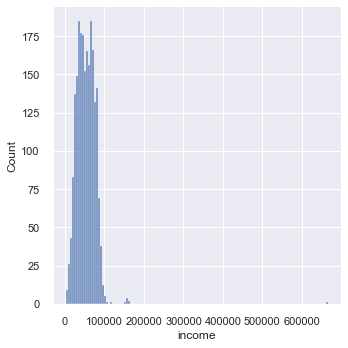

In [15]:
sns.displot(data=num_attributes, x="income");

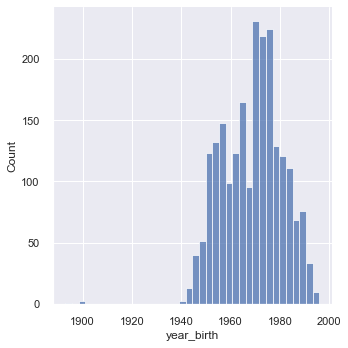

In [16]:
sns.displot(data=num_attributes, x="year_birth");

### 1.7.2 Categorical Attributes

<AxesSubplot:xlabel='education', ylabel='income'>

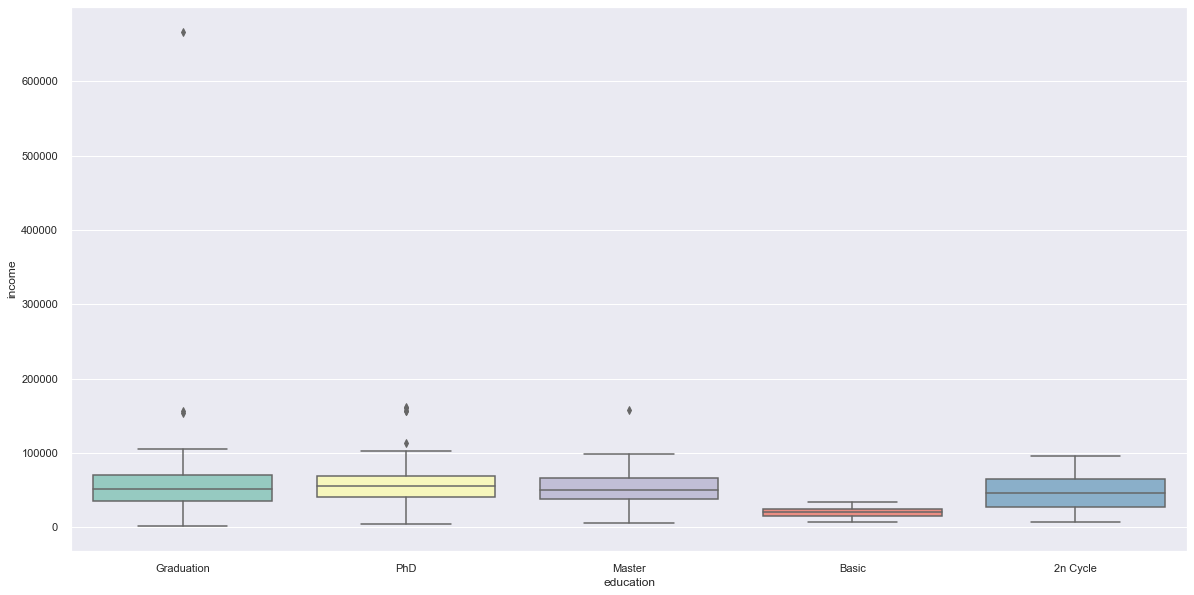

In [17]:
sns.boxplot(x="education", y="income", data=df1, palette="Set3")

<AxesSubplot:xlabel='marital_status', ylabel='income'>

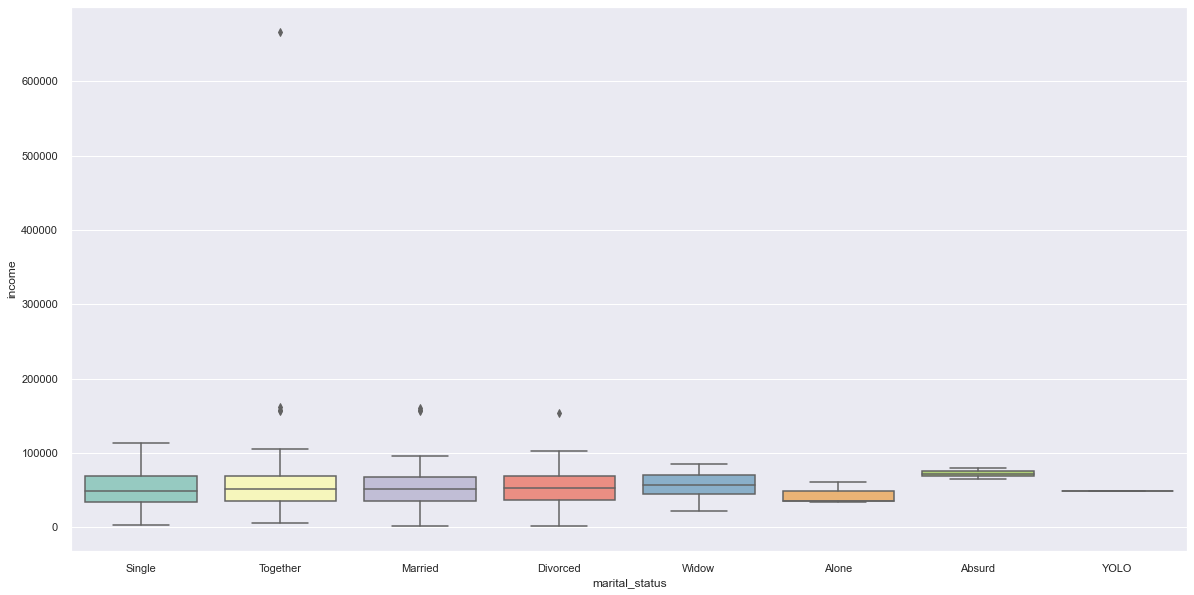

In [18]:
sns.boxplot(x="marital_status", y="income", data=df1, palette="Set3")

# 2.0 Data Filtering

In [19]:
df2 = df1.copy()

In [20]:
#drop z_ columns
df2 = df2.drop(columns=['z_costcontact', 'z_revenue'])
#replace marital_status 'alone', 'absurd' e 'yolo' to 'single'
df2['marital_status'] = df2['marital_status'].replace(['Absurd', 'Alone', 'YOLO'], 'Single')
#delete outlier with income = 666666
df2.drop(df2.loc[df2['income'] == 666666, :].index, inplace = True)

# 3.0 Feature Engineering

In [21]:
df3 = df2.copy()

In [22]:
#monetary (total amount spend)
df3['mnttotal'] = df3['mntwines'] + df3['mntfruits'] + df3['mntmeatproducts'] + df3['mntfishproducts'] + df3['mntsweetproducts'] + df3['mntgoldprods']

#total number of purchases
df3['numtotalpurchases'] = df3['numwebpurchases'] + df3['numcatalogpurchases'] + df3['numstorepurchases'] + df3['numwebvisitsmonth']

#database generation date
df3['final_date'] = pd.to_datetime('2014-08-18')

#==========frequency============
#enrollment date - final_date = total days since the person is a client
df3['total_days'] = (df3['final_date'] - df3['dt_customer']).dt.days

#total days - recency = total period (days) that the person has been on store
df3['on_store'] = df3['total_days'] - df3['recency']

#on_store / number purchases = frequency (de quanto em quantos dias a pessoa fez uma compra)
df3['frequency'] = np.round(df3['on_store'] / df3['numtotalpurchases'])

#remove clients with 0 total purchases
df3 = df3[df3['numtotalpurchases'] != 0]

#====================date================
#day_customer
df3['day_customer'] = df3['dt_customer'].dt.day

#month_customer
df3['month_customer'] = df3['dt_customer'].dt.month

#year_customer
df3['year_customer'] = df3['dt_customer'].dt.year

#===================customers age===============
df3['customer_age'] = df3['final_date'].dt.year - df3['year_birth']

In [23]:
#finding the database generation date
#df3['dt_customer'].min()
#df3.loc[df3['dt_customer'] == '2014-06-29', :]
#selecting the customer with more recency days
#df3.loc[df3['id'] == 7300, 'dt_customer']
#adding the total of days since last purchase to the date of first purchase
#df3.loc[df3['id'] == 7300, 'dt_customer'] + timedelta(days=50)

## 3.1 RFM 

In [24]:
#df_rfm = (df3[['id', 'recency', 'frequency', 'mnttotal']])
#df_rfm

# 4.0 EDA (Exploratory Data Analysis)

In [25]:
df4 = df3.copy()

In [26]:
#profile = ProfileReport(df4)
#profile.to_file('output_v3.html')
#profile.to_notebook_iframe()

## H01 Married customers should spend more

<AxesSubplot:xlabel='marital_status', ylabel='mnttotal'>

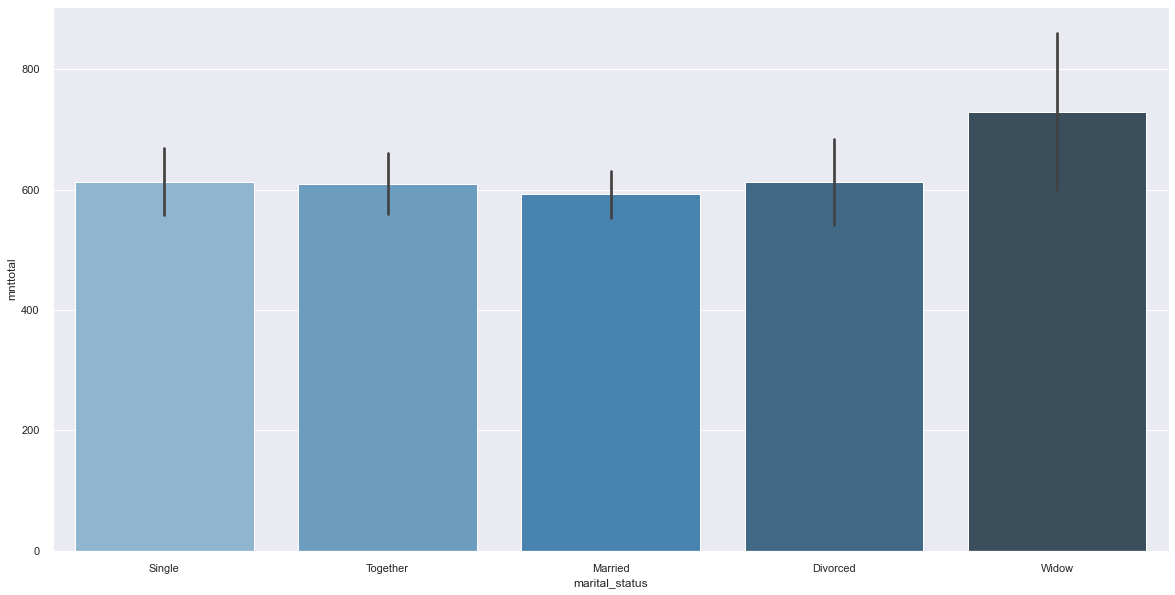

In [27]:
sns.barplot(x='marital_status', y='mnttotal', data=df4, palette='Blues_d')

## H02 Customers with kids should buy more

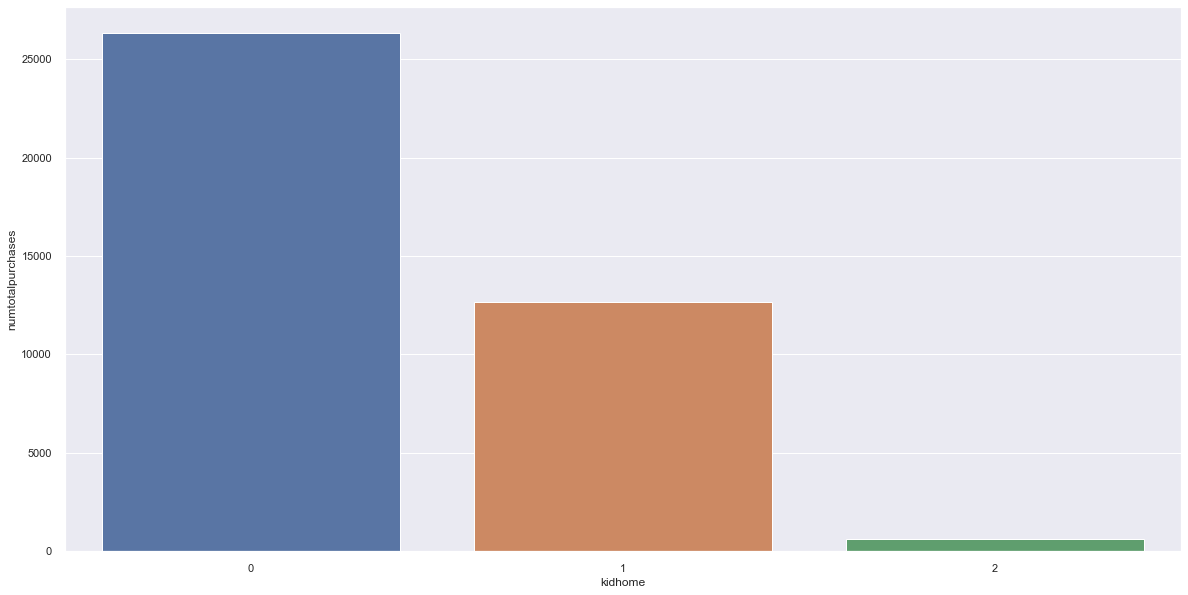

In [28]:
a = df4[['kidhome', 'numtotalpurchases']].groupby('kidhome').sum().reset_index()
sns.barplot(x='kidhome', y='numtotalpurchases', data=a);

## H03 Single customers should buy more webpurchases

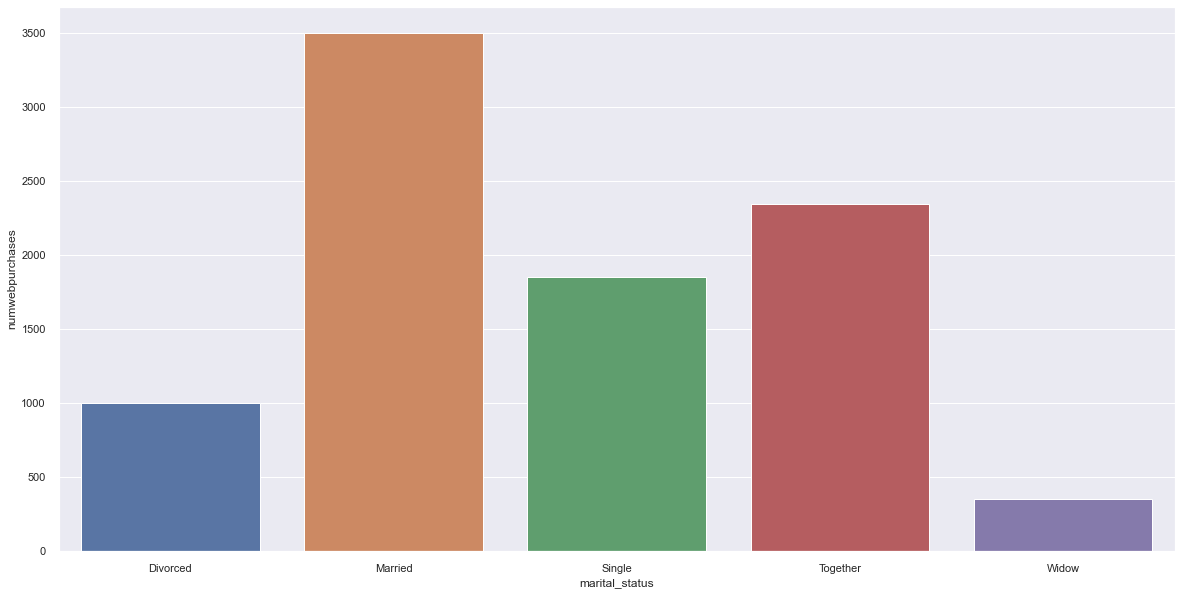

In [29]:
a = df4[['marital_status', 'numwebpurchases']].groupby('marital_status').sum().reset_index()
sns.barplot(x='marital_status', y='numwebpurchases', data=a);

## H04 Customers with PhD should have bigger incomes

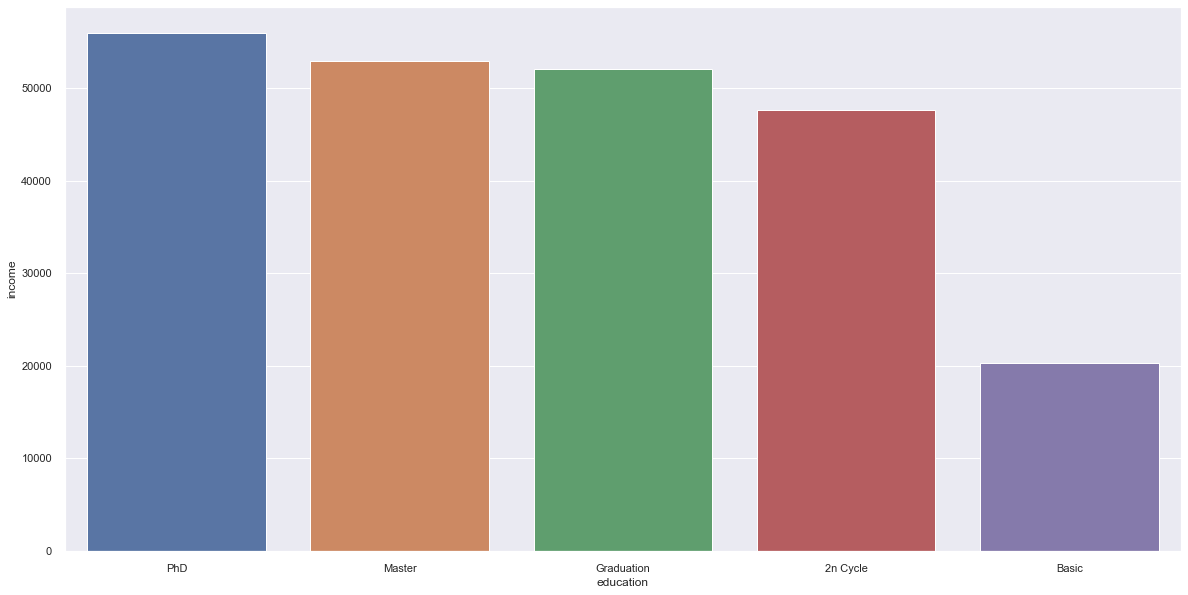

In [30]:
a = df4[['education', 'income']].groupby('education').mean().reset_index().sort_values(by='income', ascending=False)
sns.barplot(x='education', y='income', data=a);

## H05 Customers with teenhome should spend more on sweet products

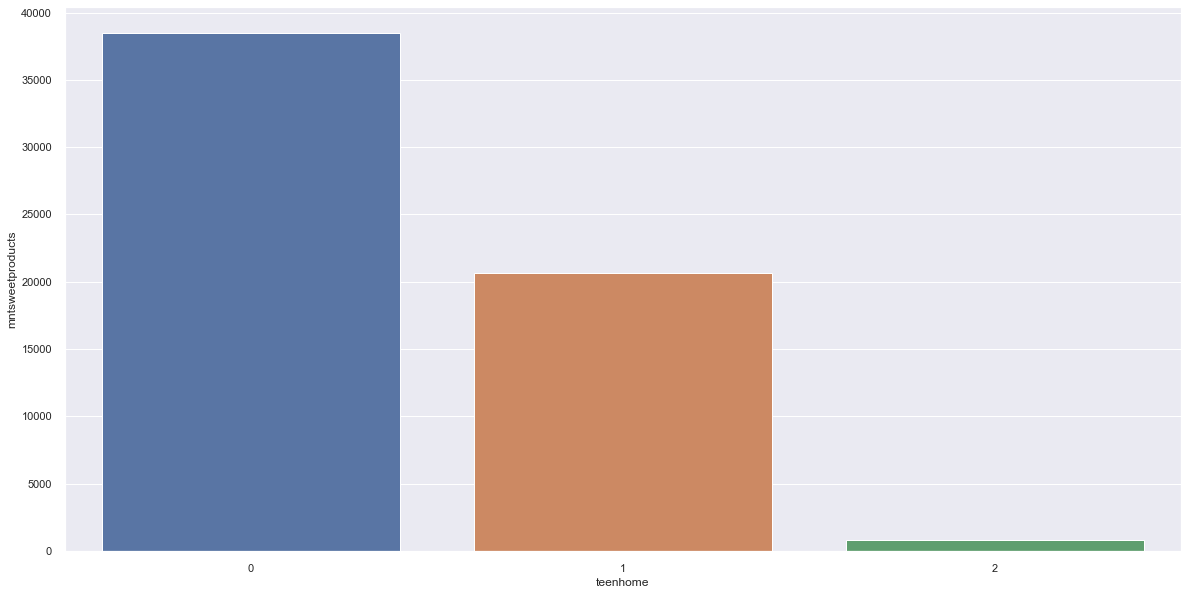

In [31]:
a = df4[['teenhome', 'mntsweetproducts']].groupby('teenhome').sum().reset_index().sort_values(by='mntsweetproducts', ascending=False)
sns.barplot(x='teenhome', y='mntsweetproducts', data=a);

## H06 Older customers should have smaller recency

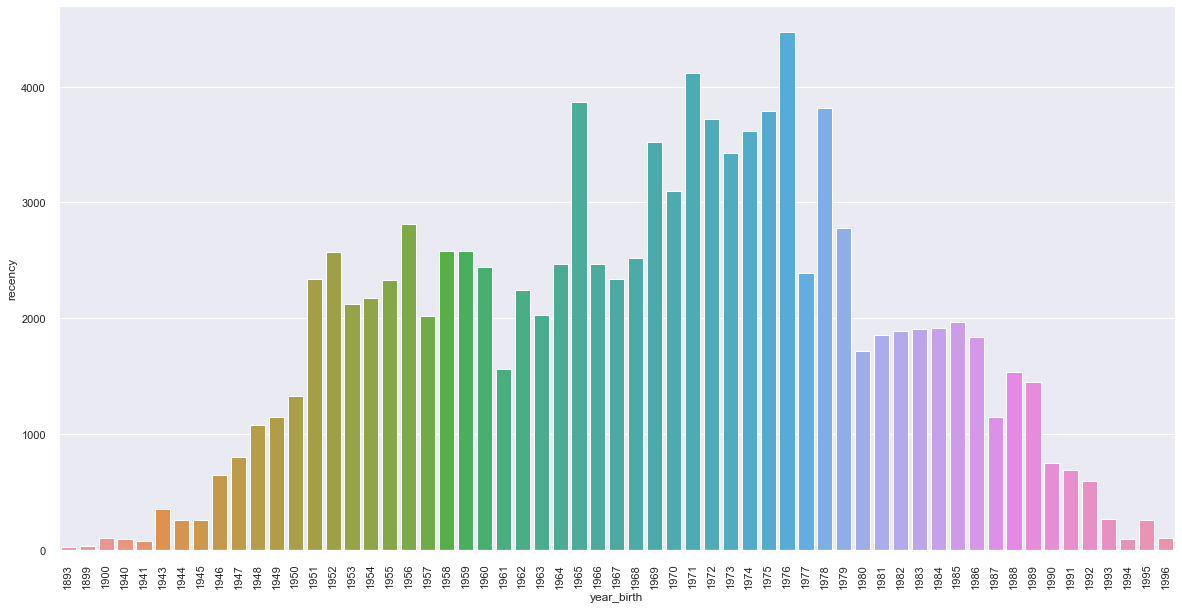

In [32]:
a = df4[['year_birth', 'recency']].groupby('year_birth').sum().reset_index().sort_values(by='recency', ascending=False)
sns.barplot(x='year_birth', y='recency', data=a);
plt.xticks(rotation=90);

# 5.0 Data Preparation

In [33]:
df5 = df4.copy()
df5_aux = df4.copy()

## 5.1 Enconding

In [34]:
le = LabelEncoder()

#education
df5['education'] = le.fit_transform(df5['education'])

#marital_status
df5['marital_status'] = le.fit_transform(df5['marital_status'])

## 5.2 Rescaling

In [35]:
mms = MinMaxScaler()
rs = RobustScaler()
ss = StandardScaler()

#year_birth > robust scaler
df5['year_birth'] = rs.fit_transform(df5[['year_birth']].values)

#income > minmax scaler
df5['income'] = ss.fit_transform(df5[['income']].values)

#recency > minmax scaler
df5['recency'] = ss.fit_transform(df5[['recency']].values)

#mtnwines > minmax scaler 
df5['mntwines'] = ss.fit_transform(df5[['mntwines']].values)

#mntfruits > minmax scaler 
df5['mntfruits'] = ss.fit_transform(df5[['mntfruits']].values)

#mntmeatproducts > minmax scaler
df5['mntmeatproducts'] = ss.fit_transform(df5[['mntmeatproducts']].values)

#mntfishproducts > minmax scaler 
df5['mntfishproducts'] = ss.fit_transform(df5[['mntfishproducts']].values)

#mntsweetproducts > minmax scaler 
df5['mntsweetproducts'] = ss.fit_transform(df5[['mntsweetproducts']].values)

#mntgoldprods > minmax scaler 
df5['mntgoldprods'] = ss.fit_transform(df5[['mntgoldprods']].values)

#numdealspurchases > minmax scaler 
df5['numdealspurchases'] = ss.fit_transform(df5[['numdealspurchases']].values)

#numwebpurchases > minmax scaler 
df5['numwebpurchases'] = ss.fit_transform(df5[['numwebpurchases']].values)

#numcatalogpurchases > minmax scaler 
df5['numcatalogpurchases'] = ss.fit_transform(df5[['numcatalogpurchases']].values)

#numstorepurchases > minmax scaler
df5['numstorepurchases'] = ss.fit_transform(df5[['numstorepurchases']].values)

#numwebvisitsmonth > minmax scaler 
df5['numwebvisitsmonth'] = ss.fit_transform(df5[['numwebvisitsmonth']].values)

#frequency > minmax scaler 
df5['frequency'] = ss.fit_transform(df5[['frequency']].values)

#mnttotal > minmax scaler 
df5['mnttotal'] = ss.fit_transform(df5[['mnttotal']].values)

#numtotalpurchases > minmax scaler 
df5['numtotalpurchases'] = ss.fit_transform(df5[['numtotalpurchases']].values)

#customer_age > minmax scaler 
df5['customer_age'] = ss.fit_transform(df5[['customer_age']].values)

## 5.3 Transformation

In [36]:
#day
df5['day_customer_sin'] =  df5['day_customer'].apply(lambda x: np.sin(x*(2 * np.pi/30)))
df5['day_customer_cos'] =  df5['day_customer'].apply(lambda x: np.cos(x*(2 * np.pi/30)))

#month
df5['month_customer_sin'] =  df5['month_customer'].apply(lambda x: np.sin(x*(2 * np.pi/12)))
df5['month_customer_cos'] =  df5['month_customer'].apply(lambda x: np.cos(x*(2 * np.pi/12)))

#year
df5['year_customer'] = rs.fit_transform(df5[['year_customer']].values)

# 6.0 Space Study

In [37]:
df6 = df5.drop(['id', 'dt_customer', 'final_date', 'total_days', 'on_store'], axis=1)
X = df6.copy()

## 6.1 PCA

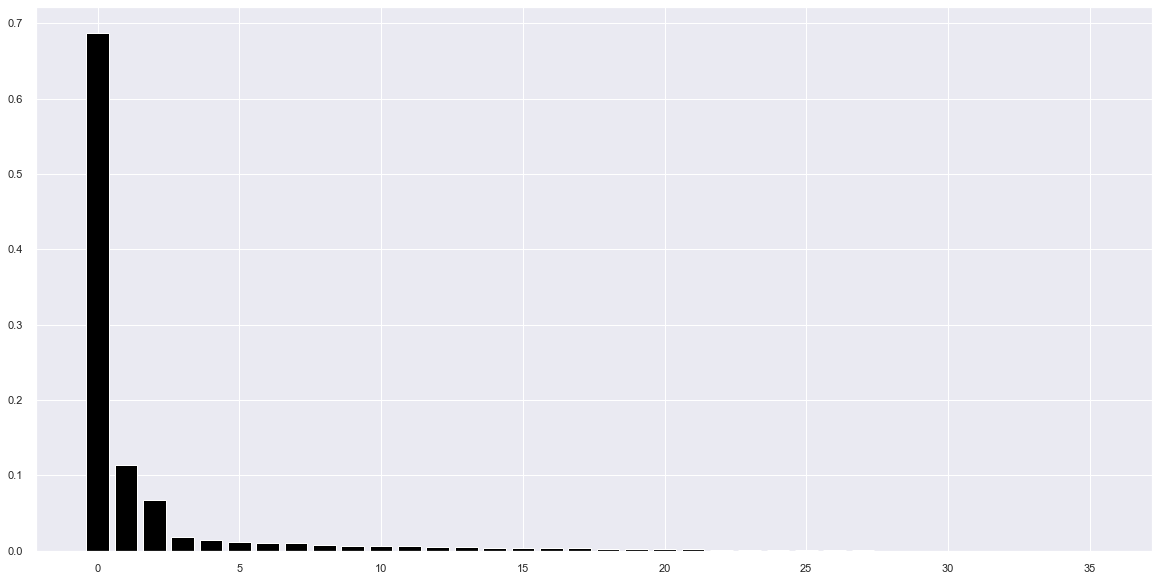

In [38]:
pca = dd.PCA(n_components=X.shape[1])
principal_components = pca.fit_transform(X)

#plot explained variables
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')

#pca components
df_pca = pd.DataFrame(principal_components)

<AxesSubplot:xlabel='0', ylabel='1'>

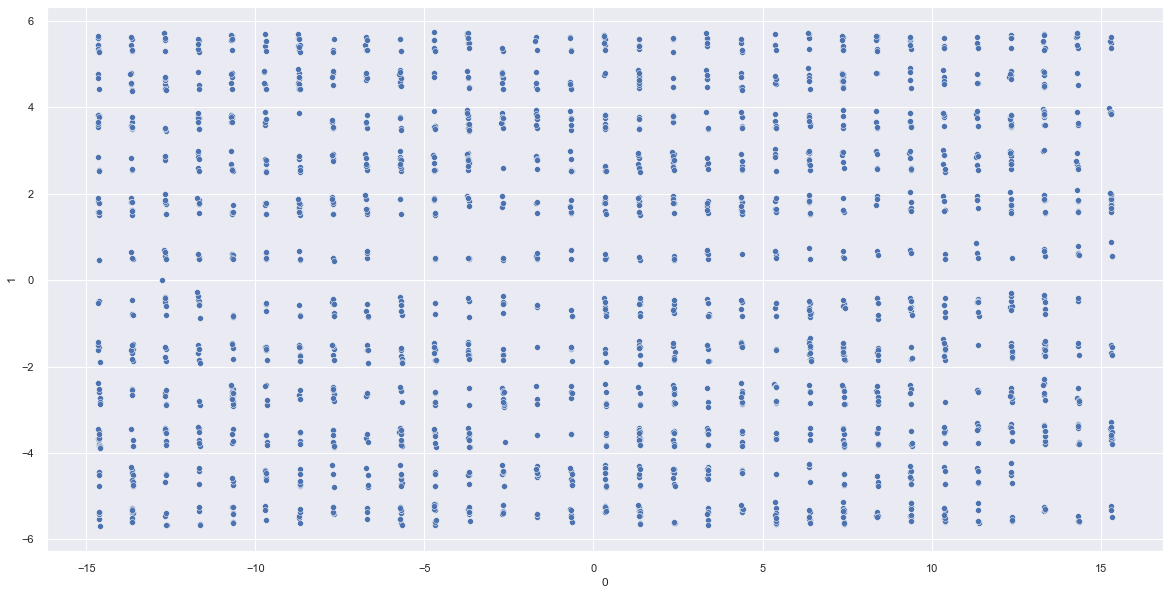

In [39]:
sns.scatterplot(x=0, y=1, data=df_pca)

## 6.2 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

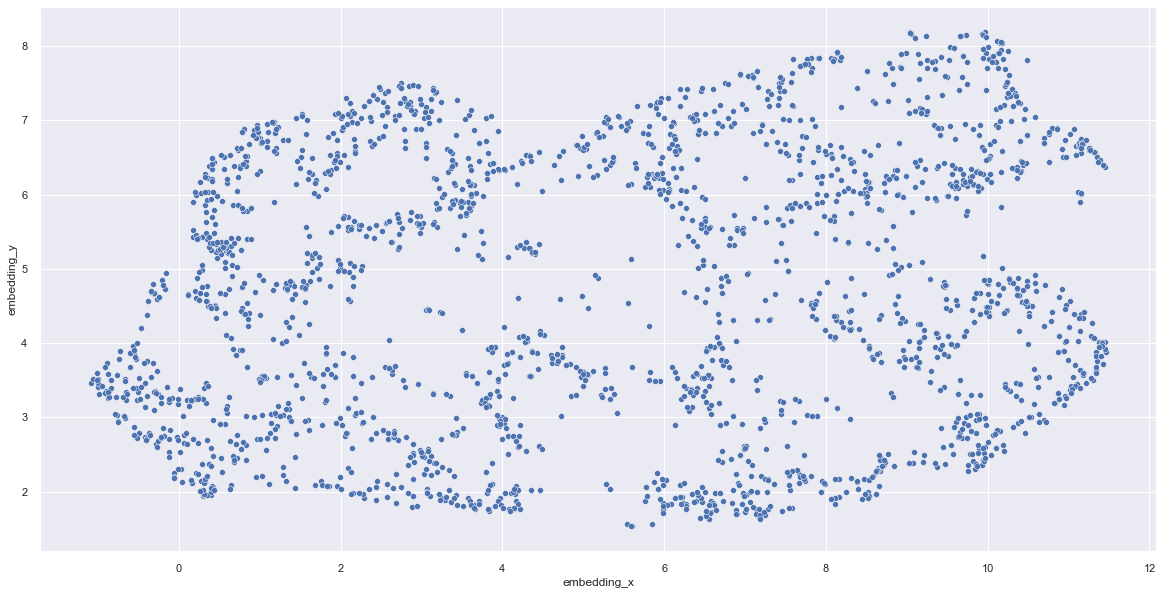

In [40]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

#embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',data=df_pca)

## 6.3 t-SNE

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

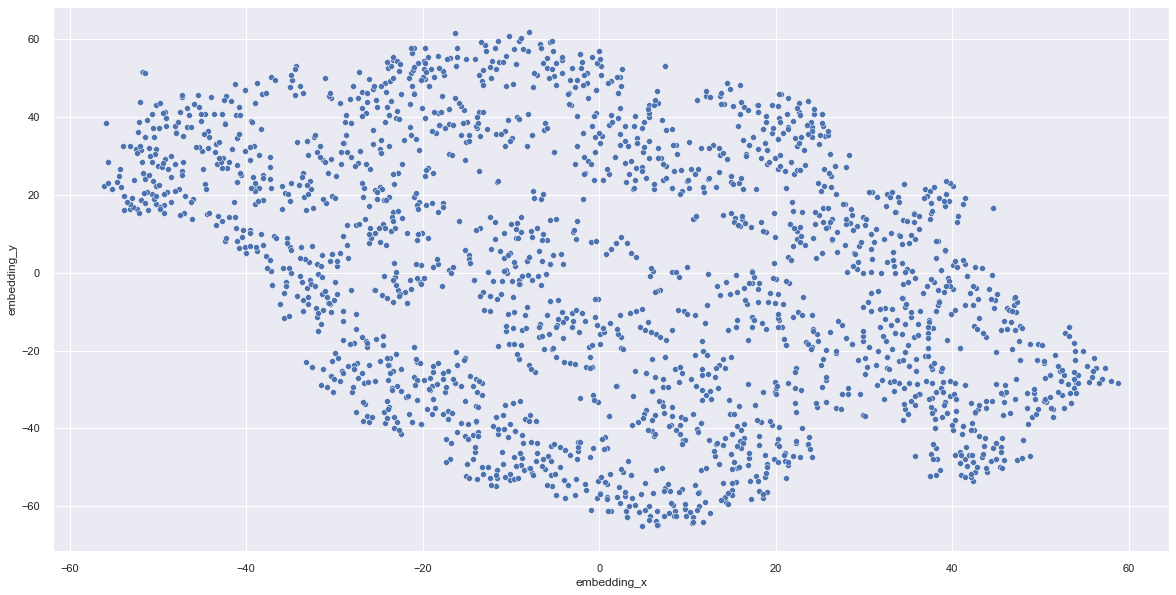

In [41]:
reducer = TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(X)

#embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',data=df_pca)

## 6.4 Tree-Based Embedding

In [42]:
#train dataset
X = df6.drop(columns=['mnttotal'], axis=1)
y = df6['mnttotal']

#model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

#model training
rf_model.fit(X, y)

#dataframe leaf
df_leaf = pd.DataFrame(rf_model.apply(X))

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

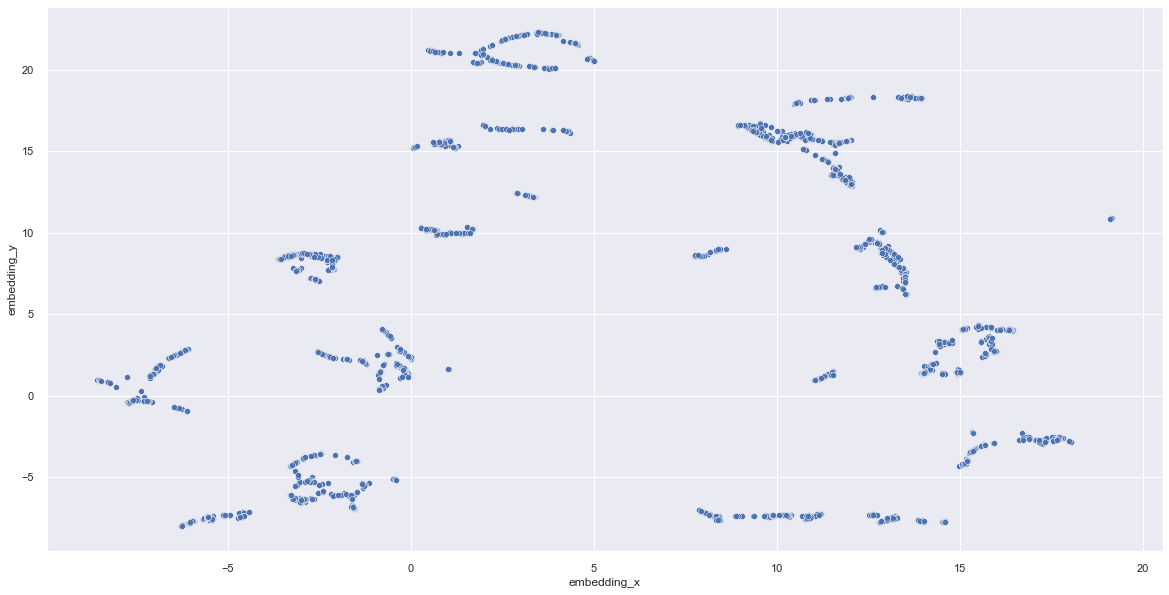

In [43]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

#embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',data=df_tree)

# 7.0 Feature Selection

In [44]:
#cols_selected = ['year_birth','education','marital_status','income','kidhome','teenhome','recency','numdealspurchases','numwebpurchases', 'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth','frequency','acceptedcmp3','acceptedcmp4','acceptedcmp5','acceptedcmp1', 'acceptedcmp2','complain','response']

In [45]:
#df7 = df6[cols_selected].copy()
#df7 = df6.copy()
df7 = df_tree.copy()
#df7 = df_pca.copy()

In [46]:
df7.head()

,embedding_x,embedding_y
0,-2.752688,-3.720357
1,11.185157,-7.307745
2,0.953416,15.464942
3,15.612389,2.352194
4,3.144756,12.315107


In [47]:
X = df7.copy()

In [48]:
clusters = [2, 3, 4, 5]

# 8.0 Hyperparameter Fine-Tunning

## 8.1 Within-cluster Sum of Square (WSS) 

WSS = o quão unidos/juntos os pontos de um mesmo cluster estão.

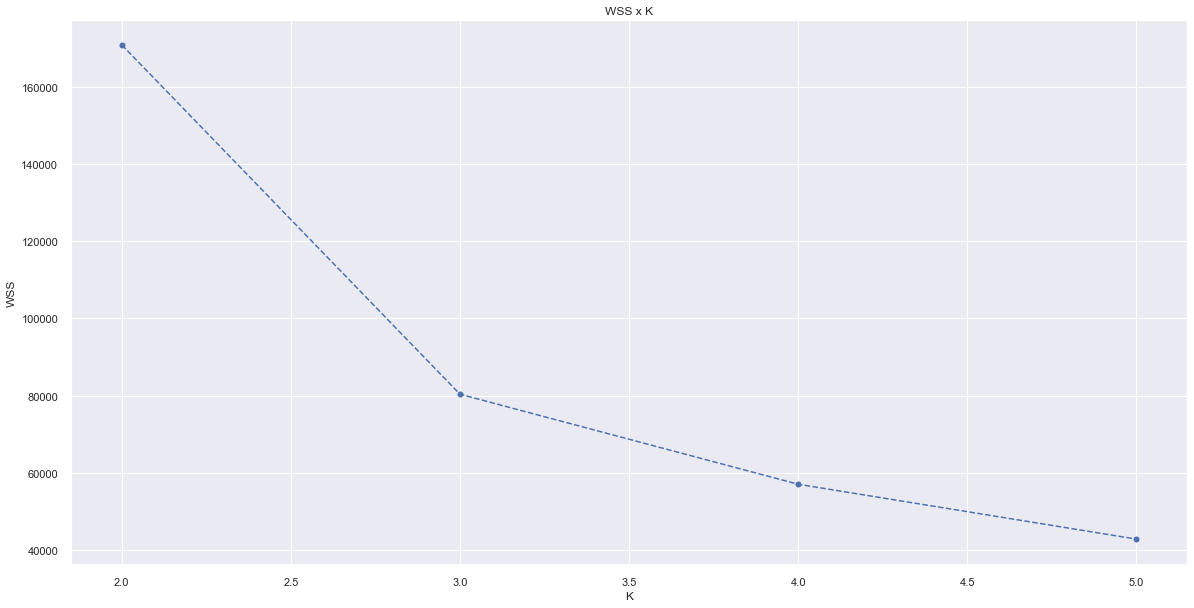

In [49]:
wss = []
for k in clusters:
    #model definition
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    
    #model training
    kmeans.fit(X)
    
    #validation
    wss.append(kmeans.inertia_)

#plot wss - Elbow Method
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('WSS')
plt.title('WSS x K')
plt.show()

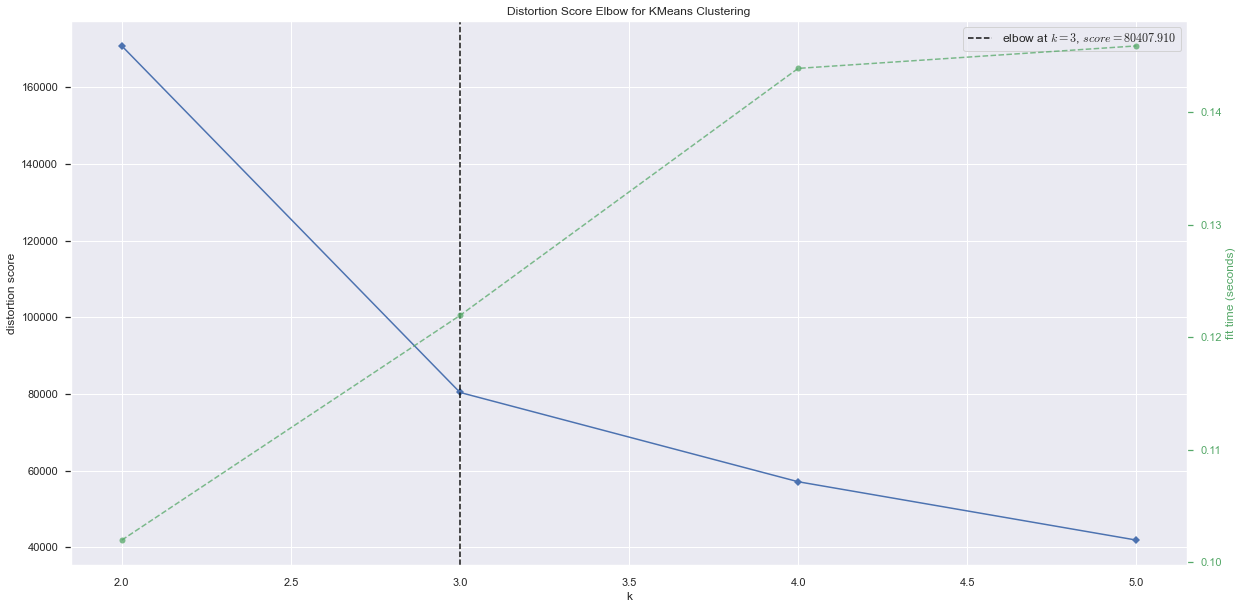

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [50]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timing=False)
kmeans.fit(X);
kmeans.show()

## 8.2 Silhouette Score

SS = o quão distante um cluster está do outro.

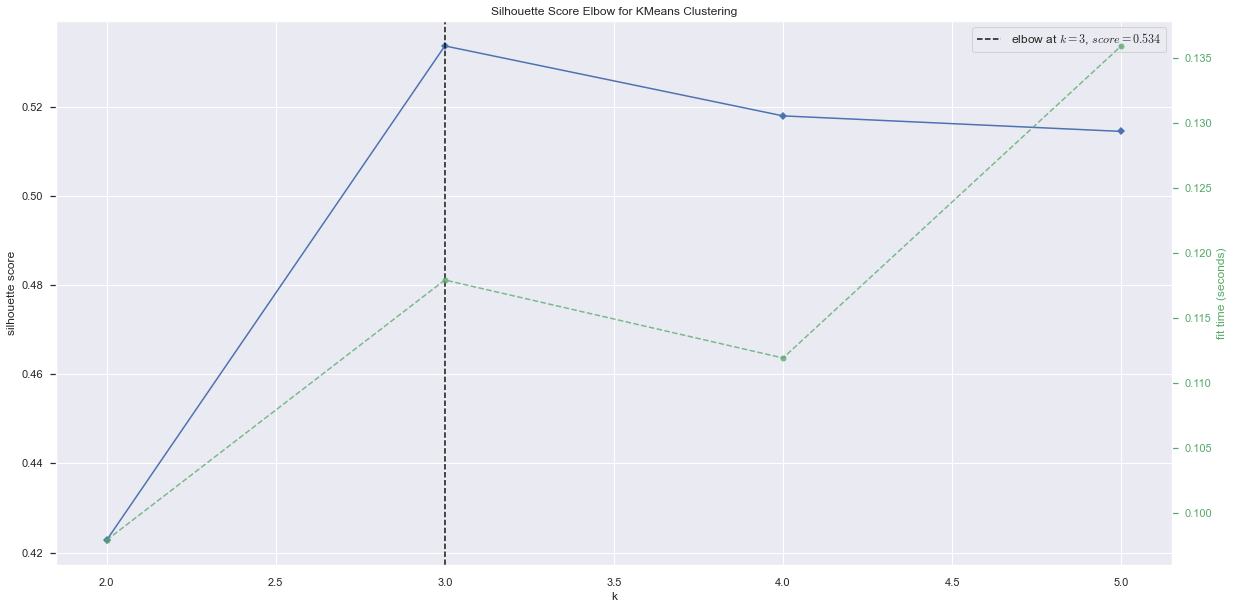

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [51]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timing=False)
kmeans.fit(X)
kmeans.show()

# 9.0 Model Training

## 9.1 Final Model

In [52]:
kmeans_list = []
#model definition
kmeans = c.KMeans(init='random', n_clusters=4, n_init=10, max_iter=300, random_state=42)

#model training
kmeans.fit(X)

#model predict
labels = kmeans.predict(X)

#performance
sil = m.silhouette_score(X, labels, metric='euclidean')
kmeans_list.append(sil)

In [53]:
#K-Means with most MMS > 0.62
#K-Means with most RS > 0.62
#K-Means with most SS > 0.62

#K-means list with all coluns [0.6204000580575603, 0.59716917235483, 0.5769169441461102, 0.5668441982524006, 0.6204000580575603]
#K-means list with columns_selected 1 [0.2081630170508744, 0.18199512325892986, 0.14027411592375846, 0.12366935879962113, 0.2081630170508744]
#K-means list with columns_selected 2 [0.2540167652414301, 0.17823501935763317, 0.10395522998719171, 0.10334174470002816]
#K-means list with columns_selected 3 [0.2098737625397743, 0.17865263483409036, 0.12632071497619024, 0.11554372861381816, 0.2098737625397743]

# 10.0 Cluster Analysis

In [54]:
df10 = X.copy()
df10['cluster'] = labels
df10.head()

,embedding_x,embedding_y,cluster
0,-2.752688,-3.720357,1
1,11.185157,-7.307745,0
2,0.953416,15.464942,2
3,15.612389,2.352194,0
4,3.144756,12.315107,2


## 10.1 Visual Inspection

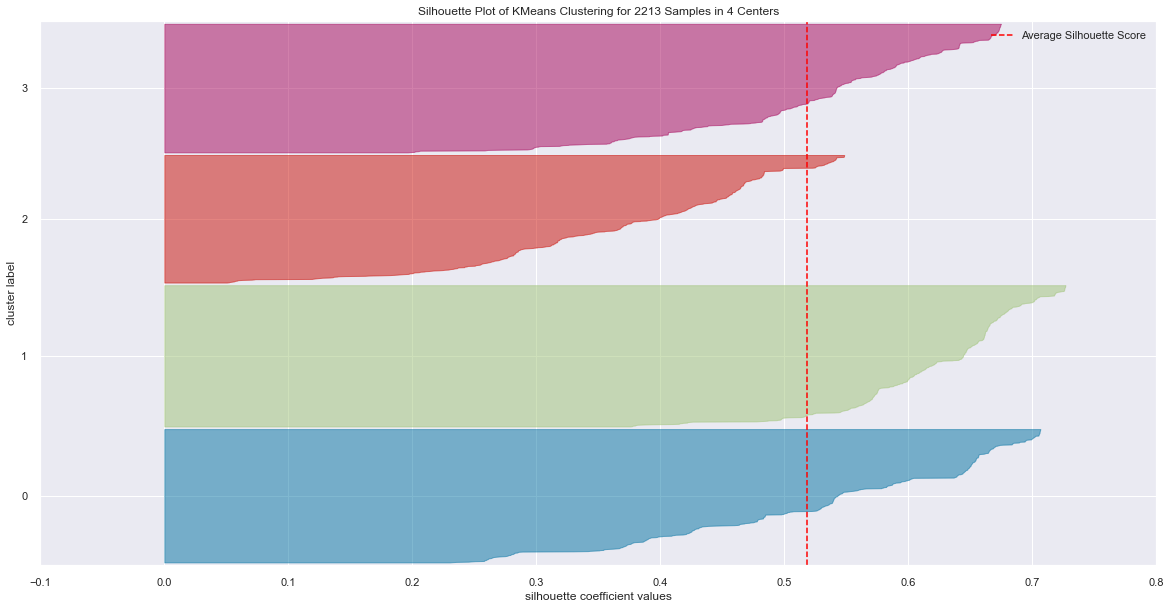

In [55]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 10.2 2D Plot 

In [56]:
#sns.pairplot(df10, hue='cluster')

## 10.3 UMAP 

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

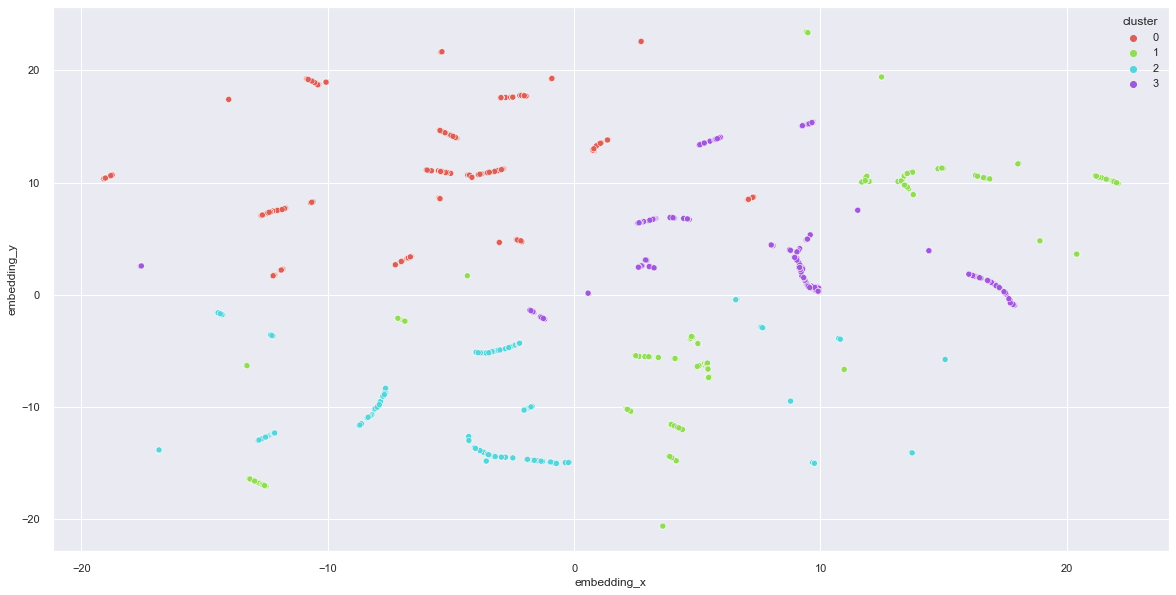

In [57]:
reducer = umap.UMAP(n_neighbors=30, random_state=42)
embedding = reducer.fit_transform(X)
df_viz = df10.copy()

#embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',
               hue='cluster',
               palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
               data=df_viz)

# 11.0 Cluster Exploratory Data Analysis

In [58]:
df11 = df4.copy()
df11['cluster'] = labels

In [59]:
#number of customers
df_cluster = df11[['id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customers'] = 100*(df_cluster['id']/df_cluster['id'].sum())

#avg_income
df_avg_income = df11[['income', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_income, how='inner', on='cluster')

#avg_recency
df_avg_recency = df11[['recency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, how='inner', on='cluster')

#avg_numdealspurchases
df_avg_numdealspurchases = df11[['numdealspurchases', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_numdealspurchases, how='inner', on='cluster')

#avg_total_spend
df_avg_spend = df11[['mnttotal', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_spend, how='inner', on='cluster')

#avg_total_purchases
df_avg_purchases = df11[['numtotalpurchases', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_purchases, how='inner', on='cluster')

In [60]:
df_cluster.head()

,cluster,id,perc_customers,income,recency,numdealspurchases,mnttotal,numtotalpurchases
0,0,556,25.124266,31589.944245,48.748201,1.661871,42.541367,10.940647
1,1,589,26.615454,75021.412564,49.923599,1.755518,1436.224109,23.293718
2,2,532,24.039765,59033.804511,48.500000,3.362782,704.372180,22.671053
3,3,536,24.220515,40382.070896,48.716418,2.608209,188.223881,14.434701


## 11.1 Mind Map

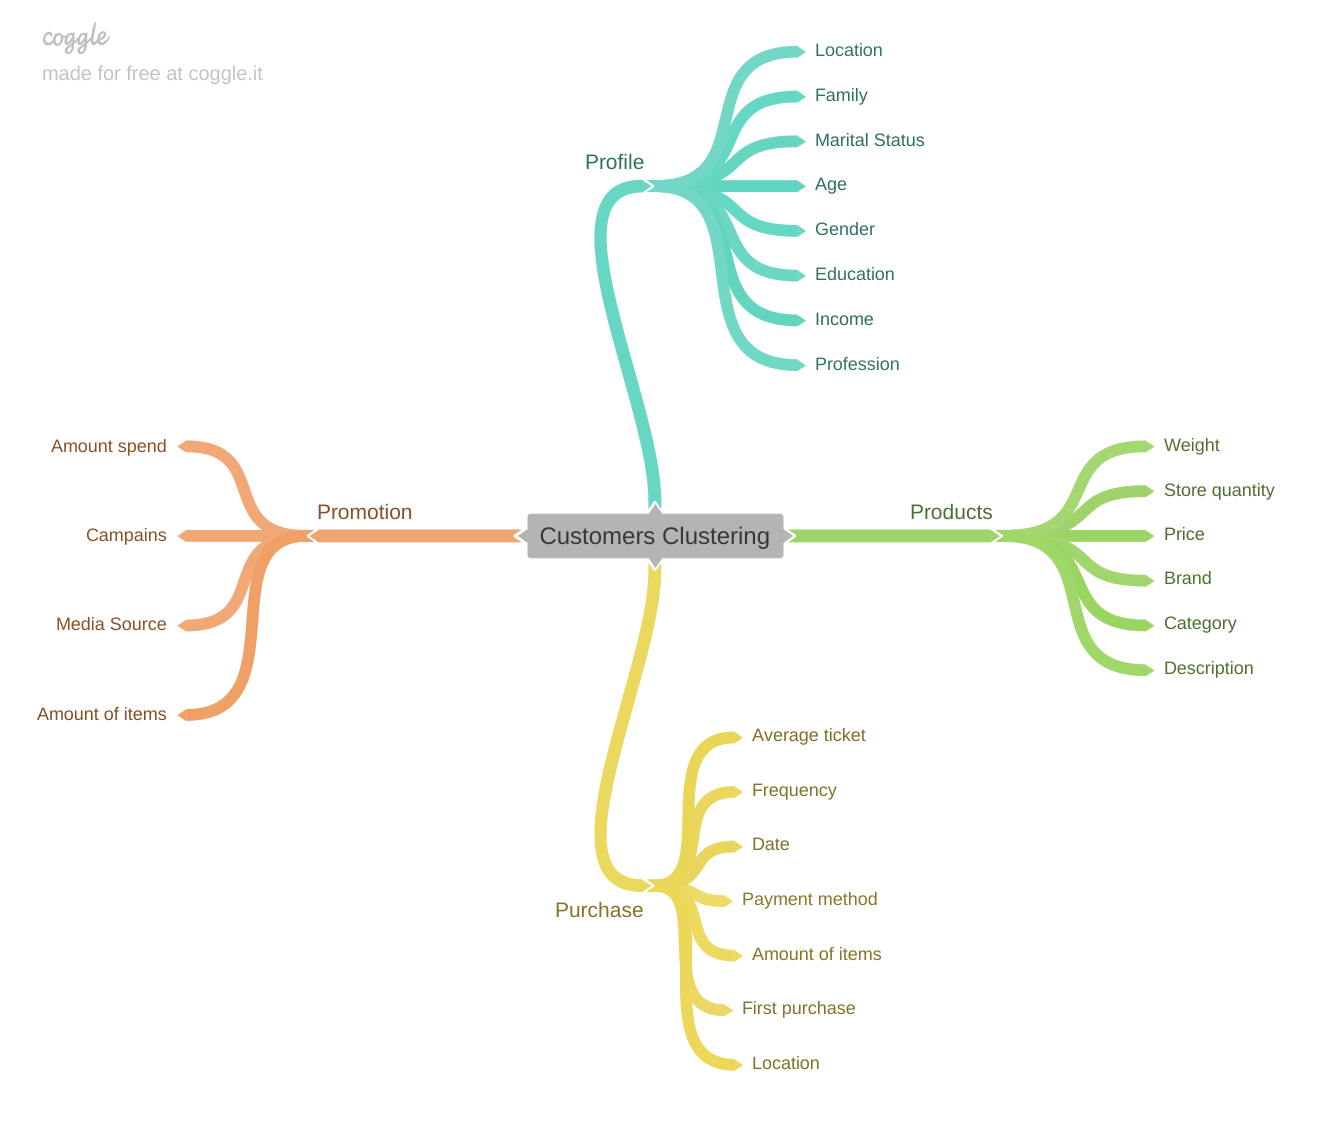

In [61]:
Image(filename='./images/Customers_Clustering_Mindmap.png')

## 11.2 Hypotheses

In [62]:
df_cluster_0 = df11.loc[df11['cluster']==0, :].reset_index(drop=True)
df_cluster_1 = df11.loc[df11['cluster']==1, :].reset_index(drop=True)
df_cluster_2 = df11.loc[df11['cluster']==2, :].reset_index(drop=True)
df_cluster_3 = df11.loc[df11['cluster']==3, :].reset_index(drop=True)

### H.1 Customers from cluster 0 are mostely maried
**TRUE** 39,4% of customers from cluster 0 are married.

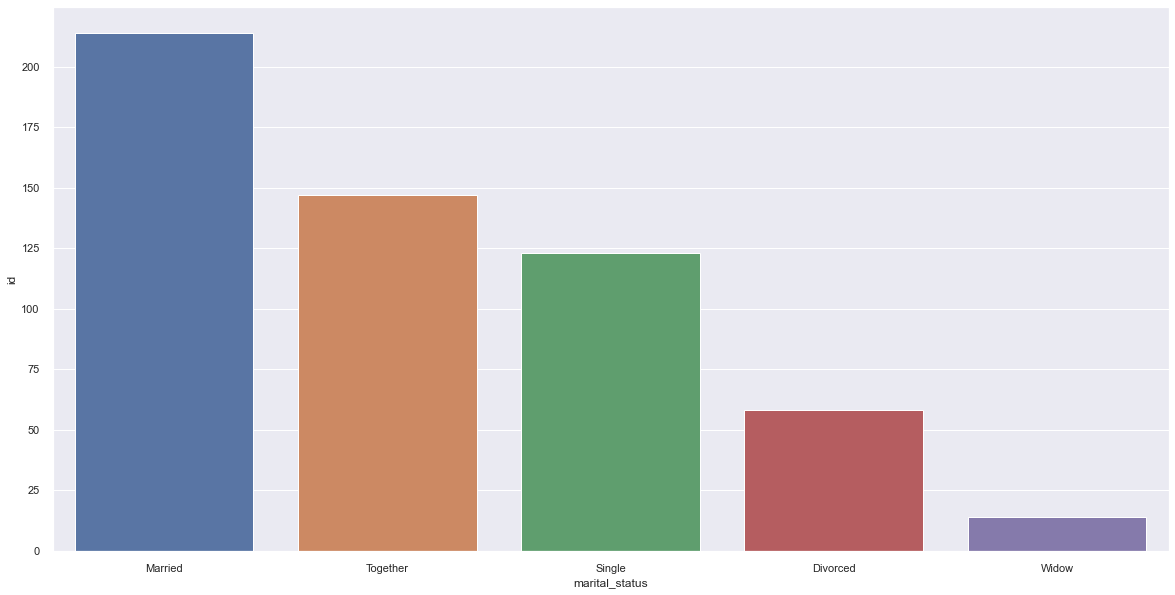

In [63]:
aux = df_cluster_0[['marital_status', 'id']].groupby('marital_status').count().sort_values(by='id', ascending=False).reset_index()
sns.barplot(x='marital_status', y='id', data=aux);

### H.2 Mostely of customer on cluster 0 have completed graduation
**TRUE** 51% of customers from cluster 0 have completed graduation.

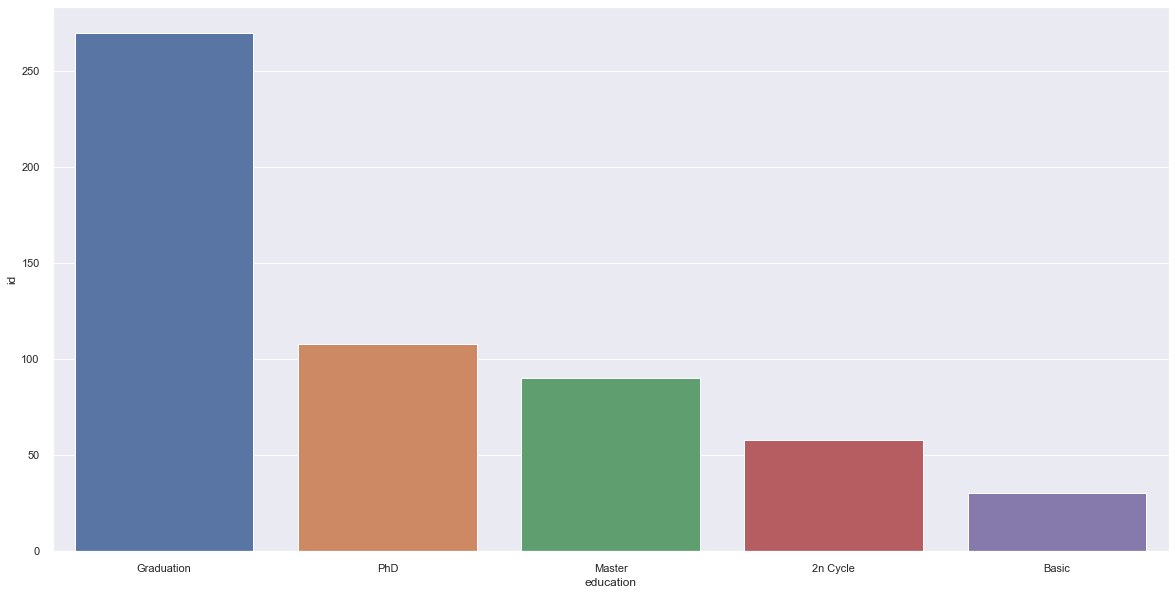

In [64]:
aux1 = df_cluster_0[['education', 'id']].groupby('education').count().sort_values(by='id', ascending=False).reset_index()
sns.barplot(x='education', y='id', data=aux1);

### H.3 Customers from cluster 0 spend more with wine products
**TRUE** customers from cluster 0 spend more on wine products

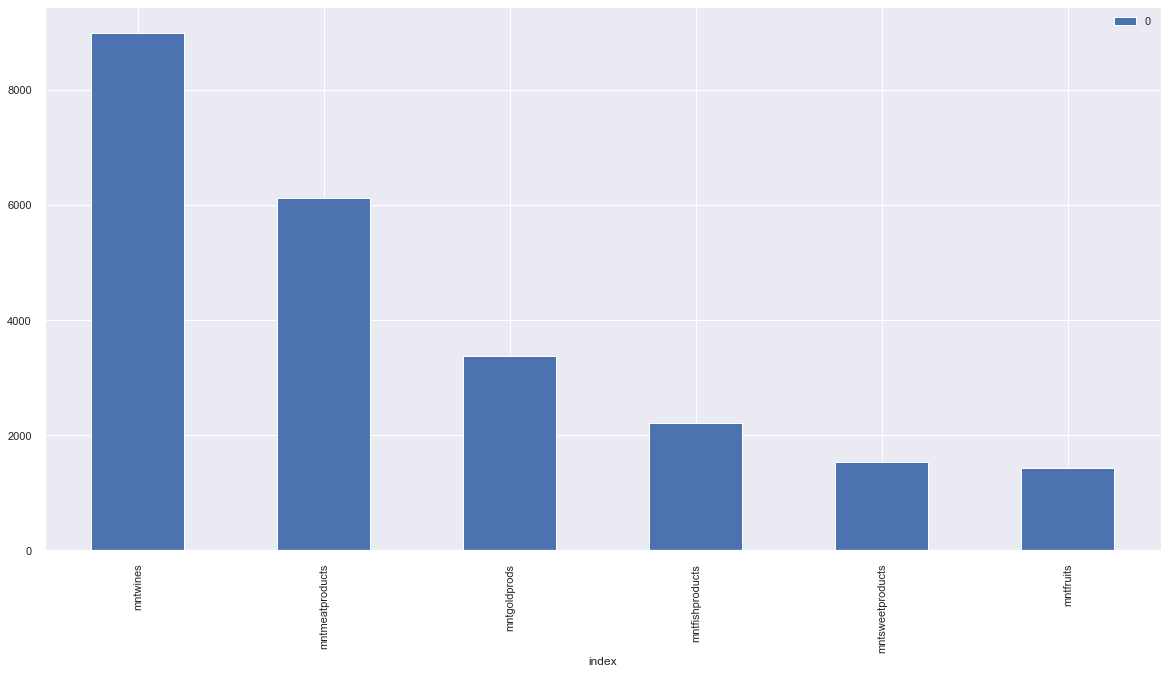

In [65]:
aux2 = df_cluster_0[['mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods']].sum().sort_values(ascending=False).reset_index()
aux2.plot(x='index', kind="bar");

### H.5 Customers from cluster 0 buy more in store
**TRUE** customers from cluster 0 have made more purchases thourgh store.

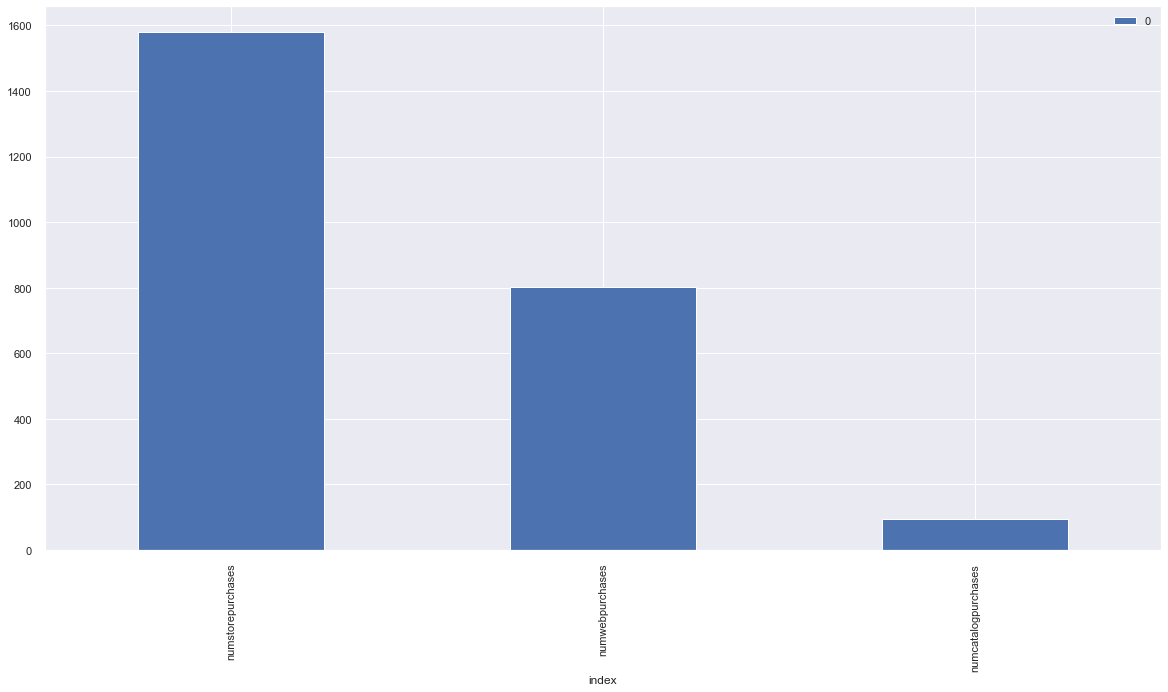

In [66]:
aux4 = df_cluster_0[['numwebpurchases','numcatalogpurchases', 'numstorepurchases']].sum().sort_values(ascending=False).reset_index()
aux4.plot(x='index', kind="bar");

### H.6 Customers from cluster 0 accepted more the 5th campaing.
**TRUE** customers from cluster 0 have accepted more the 5th campaing.

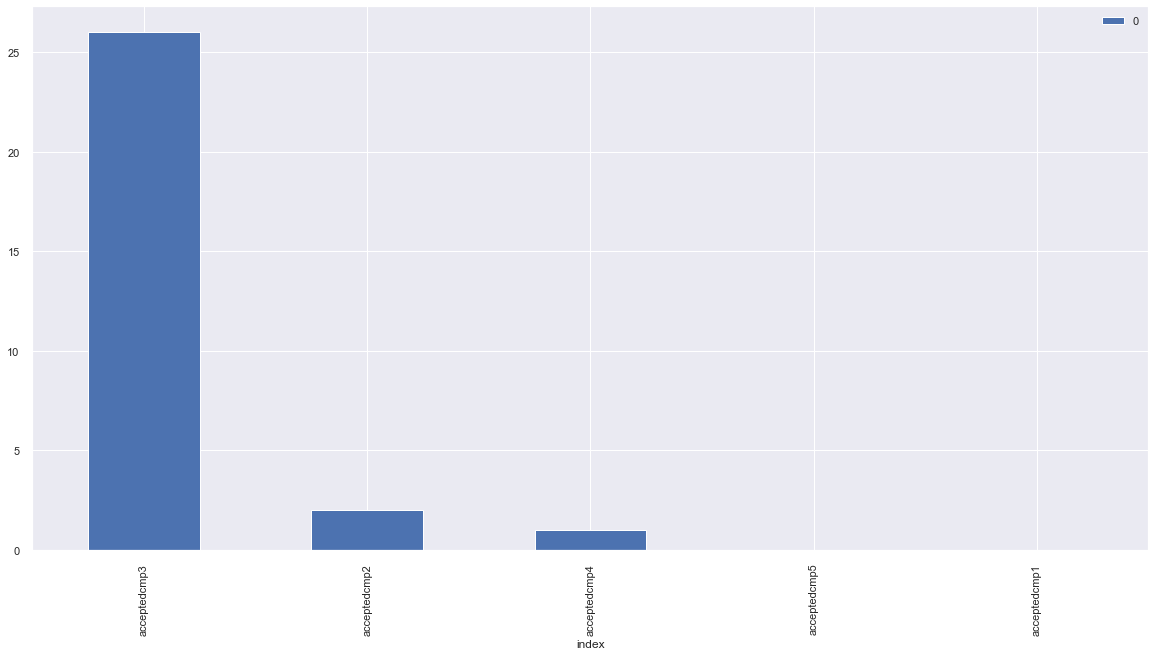

In [67]:
aux5 = df_cluster_0[['acceptedcmp3', 'acceptedcmp4', 'acceptedcmp5', 'acceptedcmp1','acceptedcmp2']].sum().sort_values(ascending=False).reset_index()
aux5.plot(x='index', kind="bar");

### H.7 Customers from cluster 0 have more teens home.
**TRUE** customers from cluster 0 have more teens home.

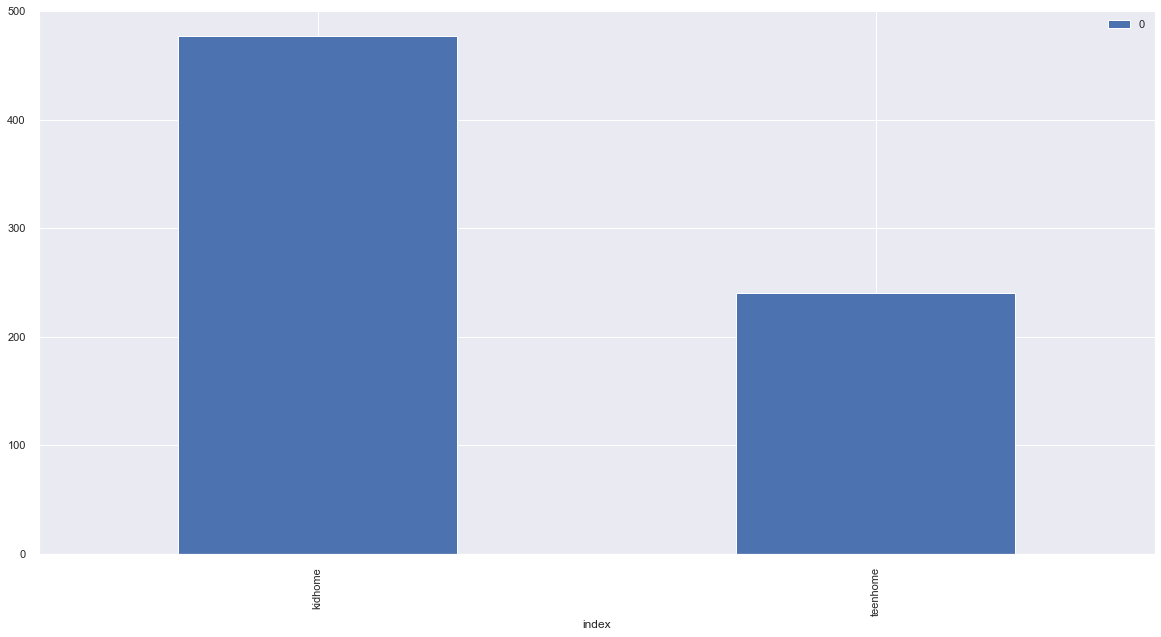

In [68]:
aux7 = df_cluster_0[['kidhome','teenhome']].sum().sort_values(ascending=False).reset_index()
aux7.plot(x='index', kind="bar");

### H.8 Customers from cluster 1 buy more in web
**FALSE** customers from cluster 1 buy more in store.

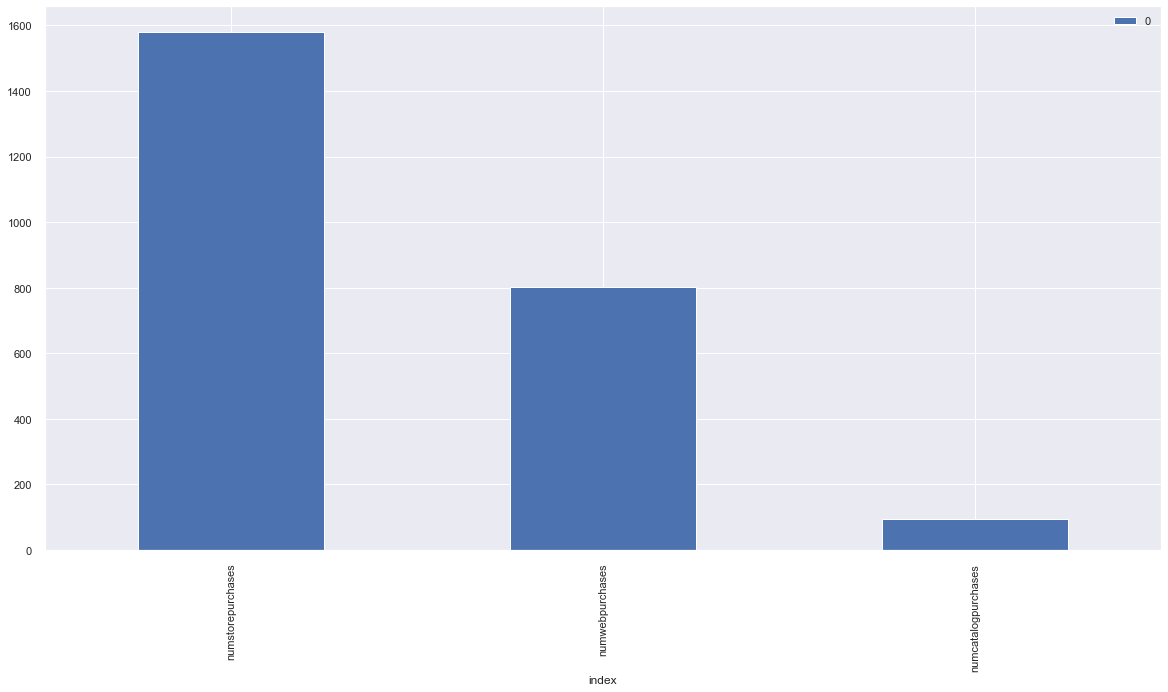

In [69]:
aux8 = df_cluster_0[['numwebpurchases','numcatalogpurchases', 'numstorepurchases']].sum().sort_values(ascending=False).reset_index()
aux8.plot(x='index', kind="bar");

### H.9 Customers from cluster 1 spend more sweet products.
**FALSE** customers from cluster 1 spend more in wines products.

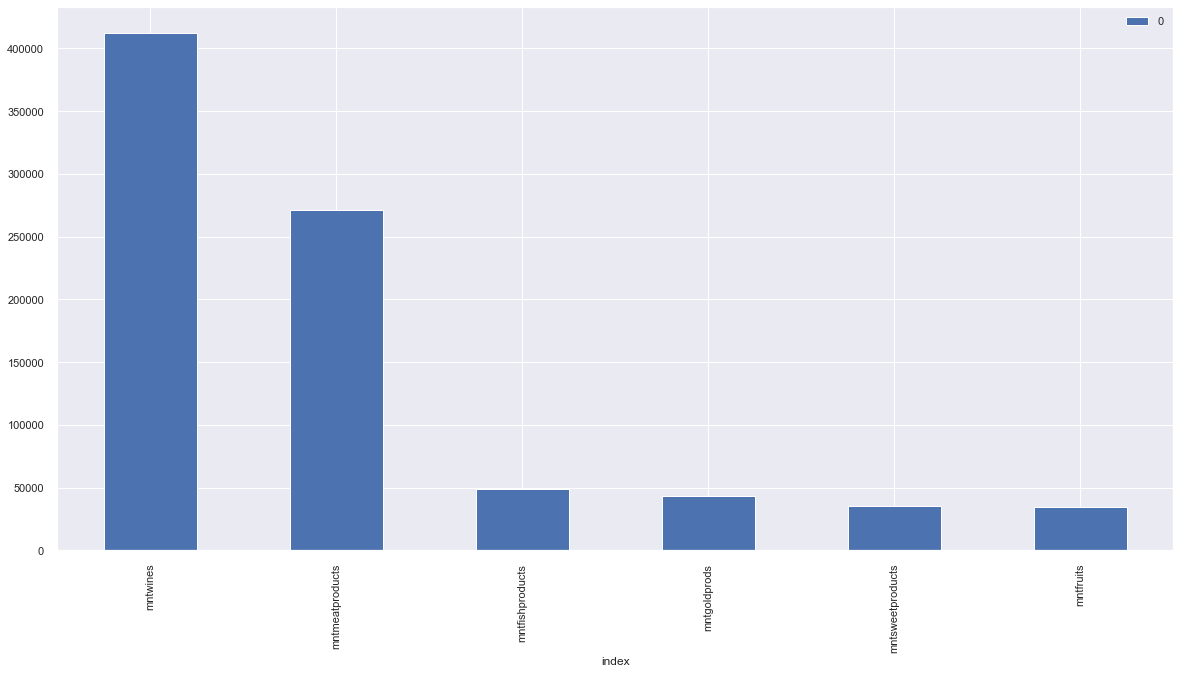

In [70]:
aux9 = df_cluster_1[['mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods']].sum().sort_values(ascending=False).reset_index()
aux9.plot(x='index', kind="bar");

### H.10 Customers from cluster 1 are mostely single
**FALSE** 38% of customers from cluster 1 are married.

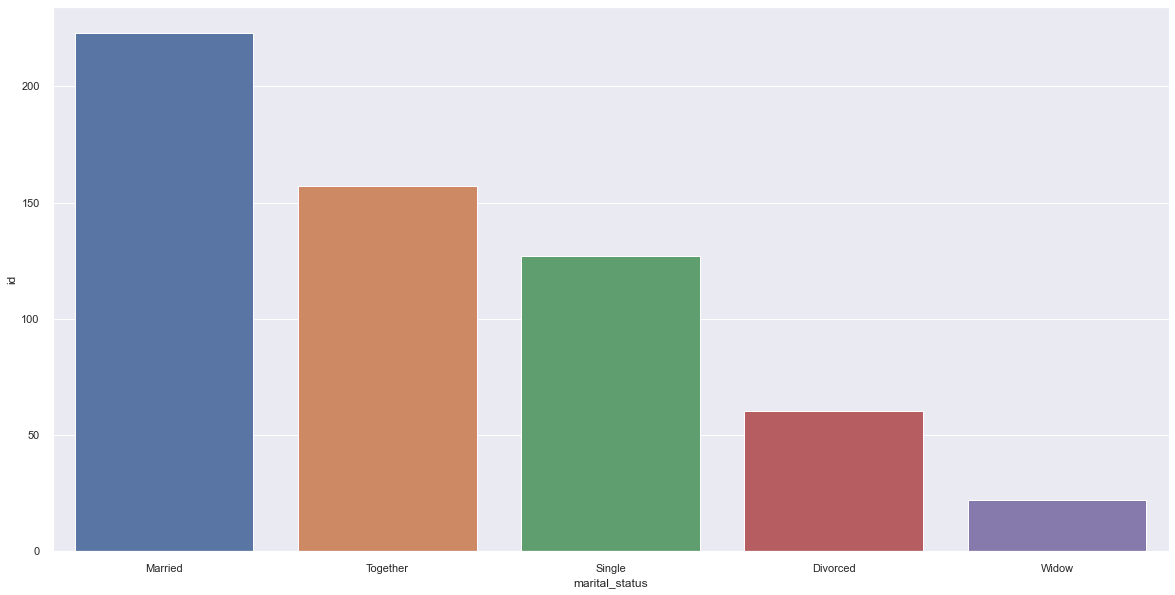

In [71]:
aux10 = df_cluster_1[['marital_status', 'id']].groupby('marital_status').count().sort_values(by='id', ascending=False).reset_index()
sns.barplot(x='marital_status', y='id', data=aux10);

### H.11 Customers from cluster 1 have mostely basic education
**FALSE** 49% of customers from cluster 1 have completed graduation.

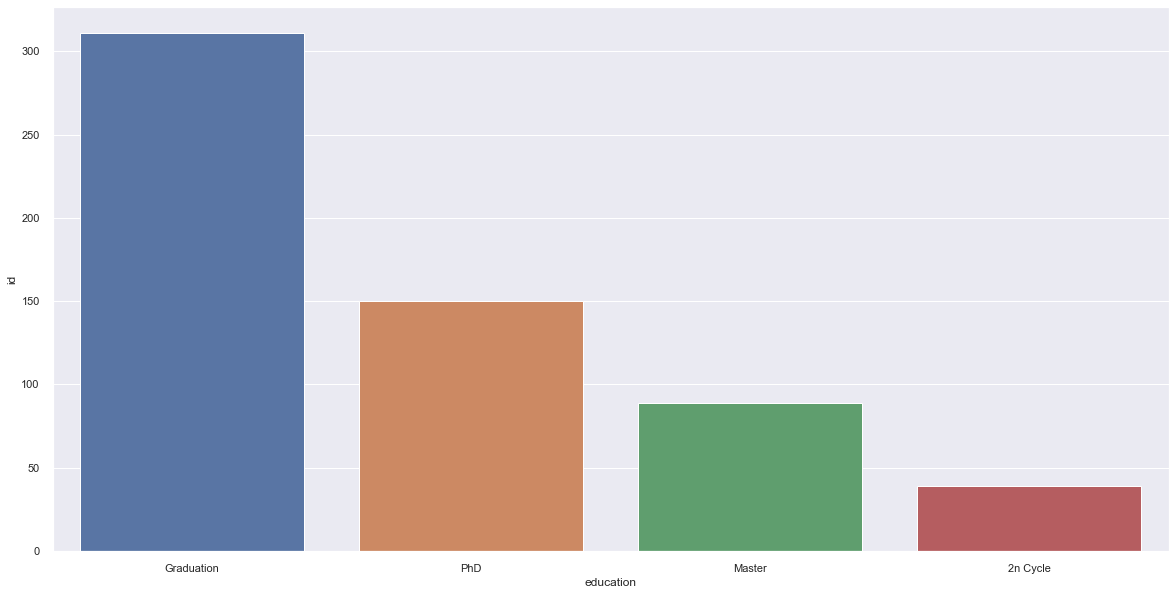

In [72]:
aux11 = df_cluster_1[['education', 'id']].groupby('education').count().sort_values(by='id', ascending=False).reset_index()
sns.barplot(x='education', y='id', data=aux11);

### H.12 Customers from cluster 0 accepted more the 3th campaing.
**TRUE** customers from cluster 0 have accepted more the 3th campaing.

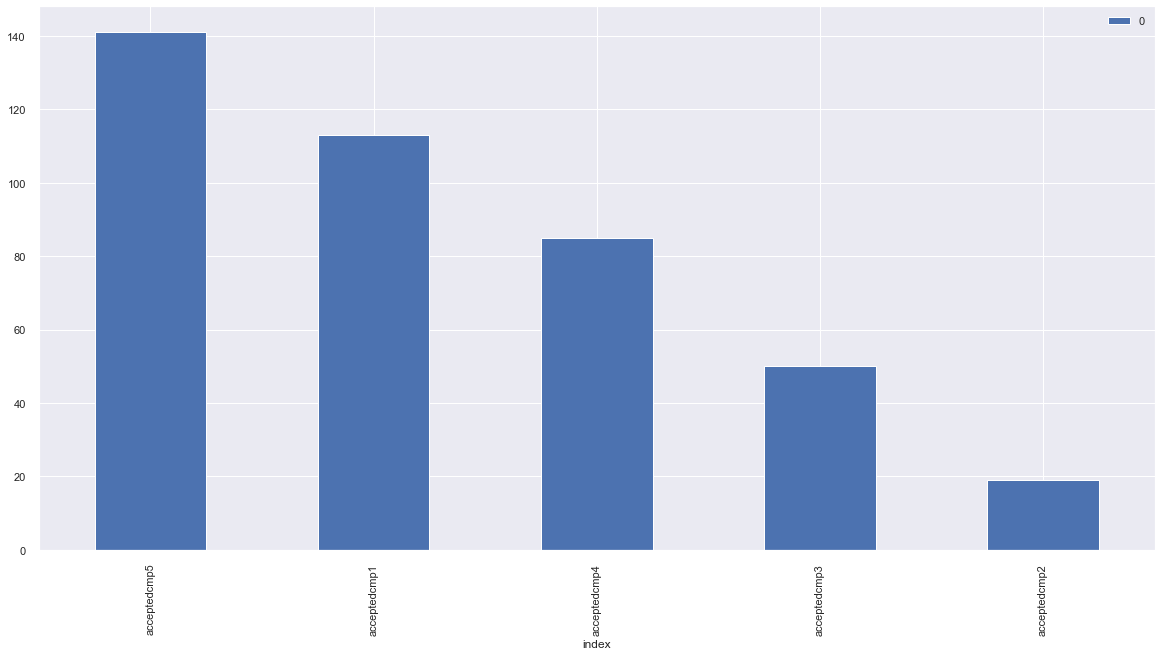

In [73]:
aux12 = df_cluster_1[['acceptedcmp3', 'acceptedcmp4', 'acceptedcmp5', 'acceptedcmp1','acceptedcmp2']].sum().sort_values(ascending=False).reset_index()
aux12.plot(x='index', kind="bar");

### H.13 Customers from cluster 1 have more kids home.
**FALSE** customers from cluster 1 have more teens home.

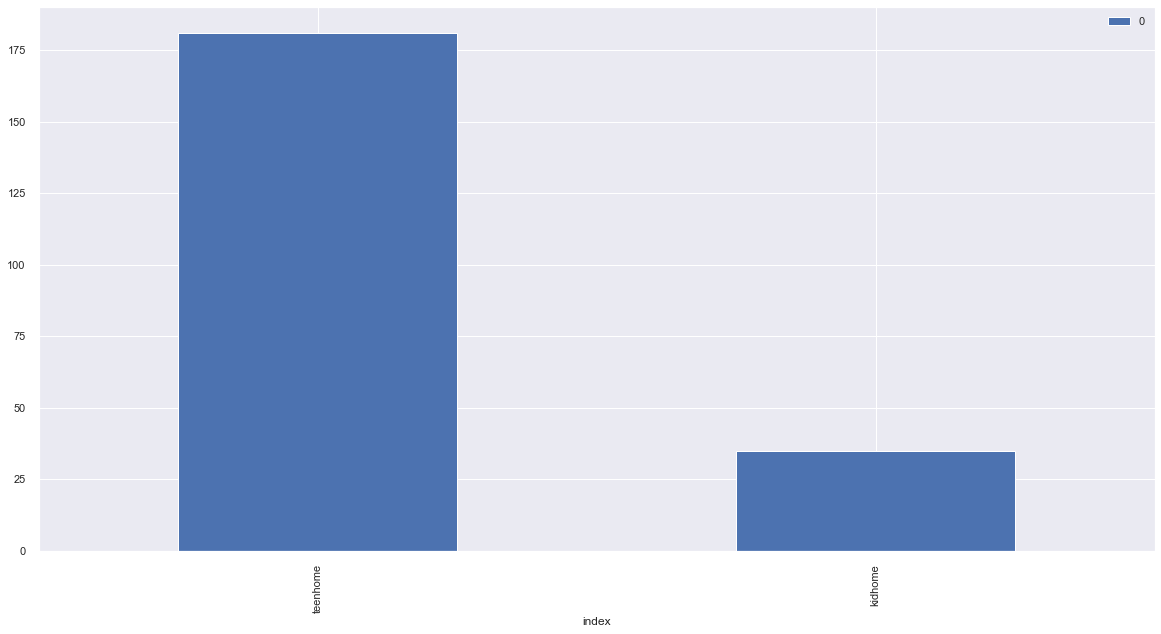

In [74]:
aux13 = df_cluster_1[['kidhome','teenhome']].sum().sort_values(ascending=False).reset_index()
aux13.plot(x='index', kind="bar");

### H.14 Customers from cluster 2 are mostely single
**FALSE** Most customers from cluster 2 are married.

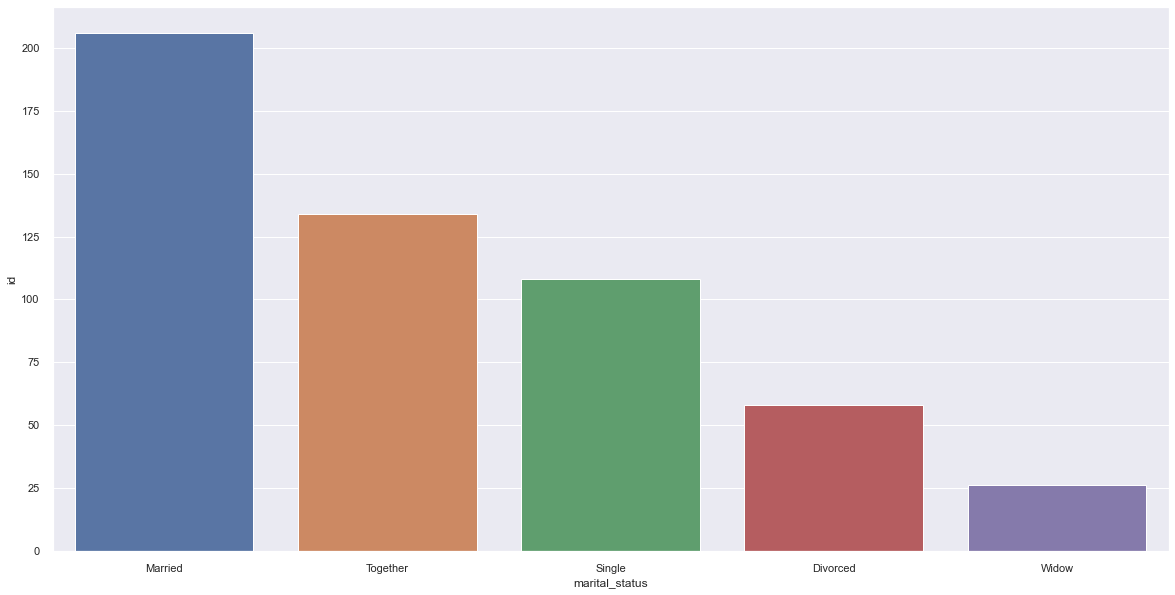

In [82]:
aux14 = df_cluster_2[['marital_status', 'id']].groupby('marital_status').count().sort_values(by='id', ascending=False).reset_index()
sns.barplot(x='marital_status', y='id', data=aux14);

### H.15 Customers from cluster 2 have mostely basic education
**FALSE** Most customers from cluster 2 have completed graduation.

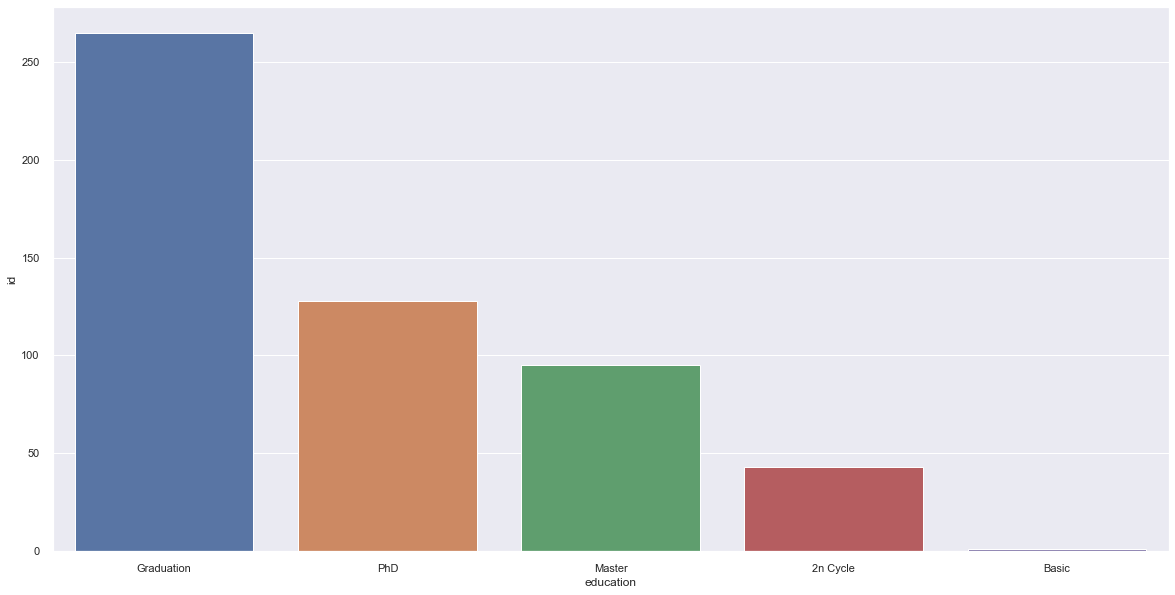

In [86]:
aux15 = df_cluster_2[['education', 'id']].groupby('education').count().sort_values(by='id', ascending=False).reset_index()
sns.barplot(x='education', y='id', data=aux15);

### H.16 Customers from cluster 3 are mostely married
**TRUE** Most customers from cluster 3 are married.

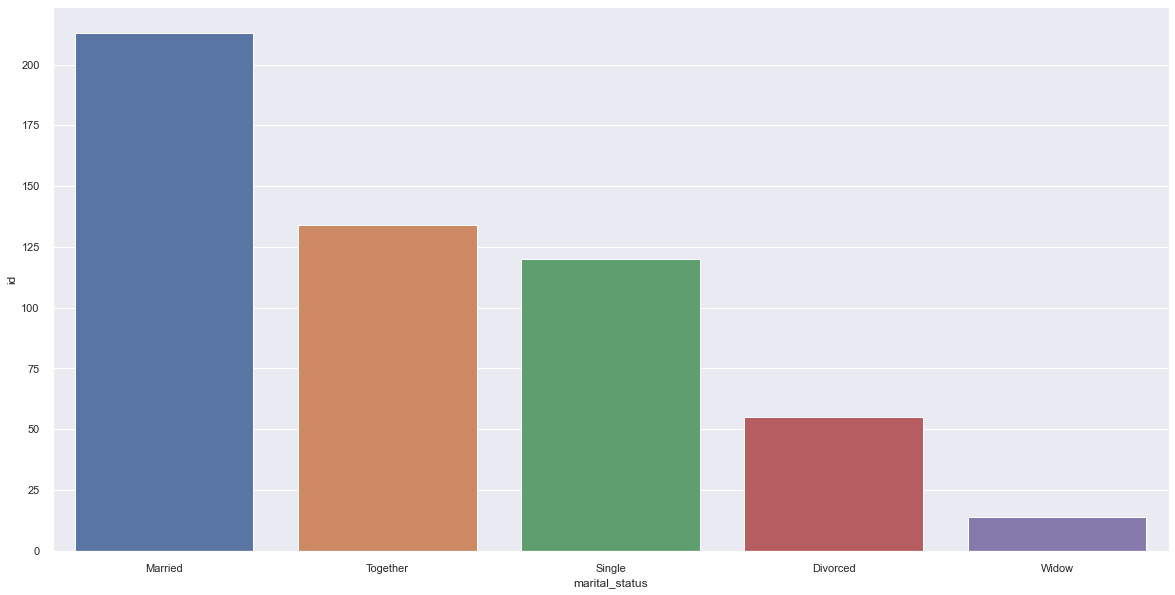

In [85]:
aux16 = df_cluster_3[['marital_status', 'id']].groupby('marital_status').count().sort_values(by='id', ascending=False).reset_index()
sns.barplot(x='marital_status', y='id', data=aux16);

### H.17 Customers from cluster 3 have mostely completed graduation
**TRUE** Most customers from cluster 3 have completed graduation.

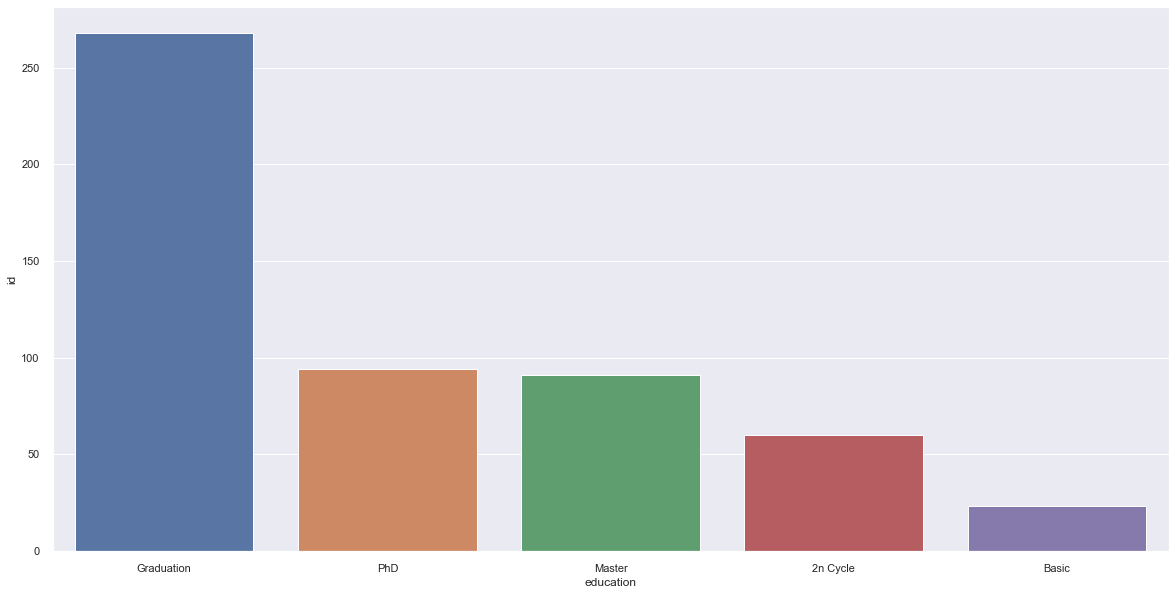

In [87]:
aux17 = df_cluster_3[['education', 'id']].groupby('education').count().sort_values(by='id', ascending=False).reset_index()
sns.barplot(x='education', y='id', data=aux17);

## 11.3 Clusters Profile 

In [76]:
print('Cluster 0')
print('- This clusters represents {}% of the database'.format(np.round(100*(df_cluster_0['id'].count()/df11['id'].count()))))
print('- The mean income for this cluster is {}'.format(np.round(df_cluster_0['income'].mean())))
print('- The average recency is {} days'.format(np.round(df_cluster_0['recency'].mean())))
print('- The average number of purchases for each customer is {}'.format(np.round(df_cluster_0['numtotalpurchases'].mean(), 2)))
print('- The average number of deal purchases is {}'.format(np.round(df_cluster_0['numdealspurchases'].mean(), 2)))
print('- The average total amount spend for each customer is ${}'.format(np.round(df_cluster_0['mnttotal'].mean(), 2)))
print('- Most customers from this cluster are {}'.format(aux['marital_status'][0]))
print('- Most customers from this cluster have the education level of {}'.format(aux1['education'][0]))

Cluster 0
- This clusters represents 25.0% of the database
- The mean income for this cluster is 31590.0
- The average recency is 49.0 days
- The average number of purchases for each customer is 10.94
- The average number of deal purchases is 1.66
- The average total amount spend for each customer is $42.54
- Most customers from this cluster are Married
- Most customers from this cluster have the education level of Graduation


In [77]:
print('Cluster 1')
print('- This clusters represents {}% of the database.'.format(np.round(100*(df_cluster_1['id'].count()/df11['id'].count()))))
print('- The mean income for this cluster is {}'.format(np.round(df_cluster_1['income'].mean())))
print('- The average recency is {} days'.format(np.round(df_cluster_1['recency'].mean())))
print('- The average number of purchases for each customer is {}'.format(np.round(df_cluster_1['numtotalpurchases'].mean(), 2)))
print('- The average number of deal purchases is {}'.format(np.round(df_cluster_1['numdealspurchases'].mean(), 2)))
print('- The average total amount spend for each customer is ${}'.format(np.round(df_cluster_1['mnttotal'].mean(), 2)))
print('- Most customers from this cluster are {}'.format(aux10['marital_status'][0]))
print('- Most customers from this cluster have the education level of {}'.format(aux11['education'][0]))

Cluster 1
- This clusters represents 27.0% of the database.
- The mean income for this cluster is 75021.0
- The average recency is 50.0 days
- The average number of purchases for each customer is 23.29
- The average number of deal purchases is 1.76
- The average total amount spend for each customer is $1436.22
- Most customers from this cluster are Married
- Most customers from this cluster have the education level of Graduation


In [83]:
print('Cluster 2')
print('- This clusters represents {}% of the database.'.format(np.round(100*(df_cluster_2['id'].count()/df11['id'].count()))))
print('- The mean income for this cluster is {}'.format(np.round(df_cluster_2['income'].mean())))
print('- The average recency is {} days'.format(np.round(df_cluster_2['recency'].mean())))
print('- The average number of purchases for each customer is {}'.format(np.round(df_cluster_2['numtotalpurchases'].mean(), 2)))
print('- The average number of deal purchases is {}'.format(np.round(df_cluster_2['numdealspurchases'].mean(), 2)))
print('- The average total amount spend for each customer is ${}'.format(np.round(df_cluster_2['mnttotal'].mean(), 2)))
print('- Most customers from this cluster are {}'.format(aux14['marital_status'][0]))
print('- Most customers from this cluster have the education level of {}'.format(aux15['education'][0]))

Cluster 2
- This clusters represents 24.0% of the database.
- The mean income for this cluster is 59034.0
- The average recency is 48.0 days
- The average number of purchases for each customer is 22.67
- The average number of deal purchases is 3.36
- The average total amount spend for each customer is $704.37
- Most customers from this cluster are Married
- Most customers from this cluster have the education level of Graduation


In [88]:
print('Cluster 3')
print('- This clusters represents {}% of the database.'.format(np.round(100*(df_cluster_3['id'].count()/df11['id'].count()))))
print('- The mean income for this cluster is {}'.format(np.round(df_cluster_3['income'].mean())))
print('- The average recency is {} days'.format(np.round(df_cluster_3['recency'].mean())))
print('- The average number of purchases for each customer is {}'.format(np.round(df_cluster_3['numtotalpurchases'].mean(), 2)))
print('- The average number of deal purchases is {}'.format(np.round(df_cluster_3['numdealspurchases'].mean(), 2)))
print('- The average total amount spend for each customer is ${}'.format(np.round(df_cluster_3['mnttotal'].mean(), 2)))
print('- Most customers from this cluster are {}'.format(aux16['marital_status'][0]))
print('- Most customers from this cluster have the education level of {}'.format(aux17['education'][0]))

Cluster 3
- This clusters represents 24.0% of the database.
- The mean income for this cluster is 40382.0
- The average recency is 49.0 days
- The average number of purchases for each customer is 14.43
- The average number of deal purchases is 2.61
- The average total amount spend for each customer is $188.22
- Most customers from this cluster are Married
- Most customers from this cluster have the education level of Graduation


# 12.0 Deploy